# Analyzing Neural Time Series Data: Chapter 19

### Intertrial Phase Clustering

Converted from MATLAB to Python by Andrew J. Graves on 05/12/20

In [1]:
# Get matplotlib magic
%matplotlib notebook 

# Import modules
import numpy as np
import matplotlib.pyplot as plt
from math import ceil, floor
from scipy.signal import hilbert
from mne.filter import filter_data

# Run data extraction and useful function script; double quotes work for Windows and Mac paths
%run "data_and_funcs.ipynb"

### Figure 19.1

Figure 19.1 shows two vectors (black lines) with similar angles. The average vector (solid grey line) reflects their proximity, but a vector formed by averaging their angles in radians (dashed gray line) does not reflect the two vectors. This is an illustration of why averaging phase angle radian values is inappropriate.

<IPython.core.display.Javascript object>


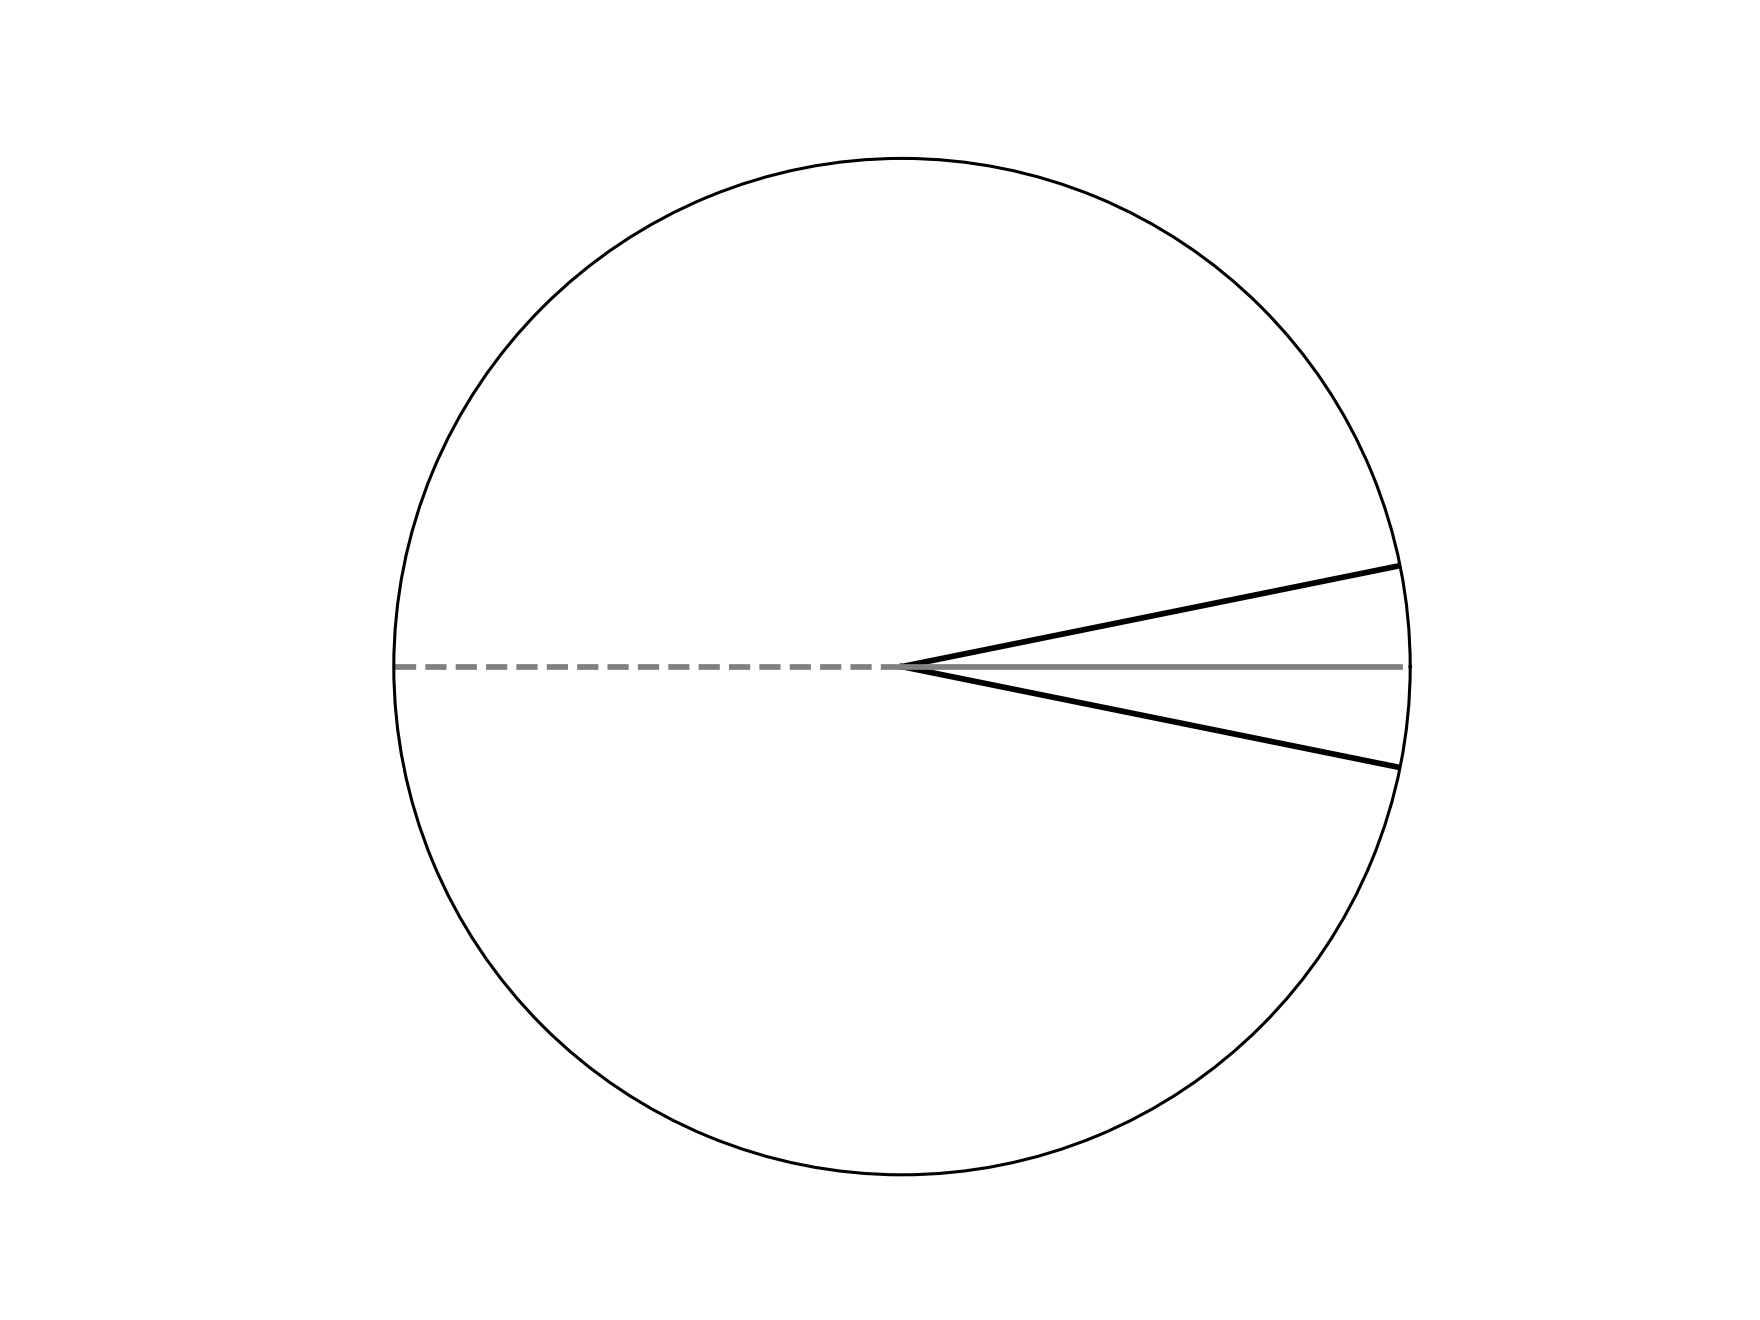

In [2]:
# Define angles
a = np.array([.2, 2 * np.pi - .2])

plt.figure()

# Plot unit vectors defined by the angles
plt.polar([[0, 0], a], [[0, 0], [1, 1]], color='black')

# Plot a unit vector with the average angle
plt.polar([0, np.mean(a)], [0, 1], color='grey', linestyle='dashed')

# Plot the average vector
plt.polar([0, np.angle(np.mean(np.exp(1j * a)))], 
          [0, np.abs(np.mean(np.exp(1j * a)))], 
          color='grey')

plt.xticks([])
plt.yticks([])
plt.ylim([0, 1])
plt.grid(False)

plt.show()

### Figure 19.2

<IPython.core.display.Javascript object>


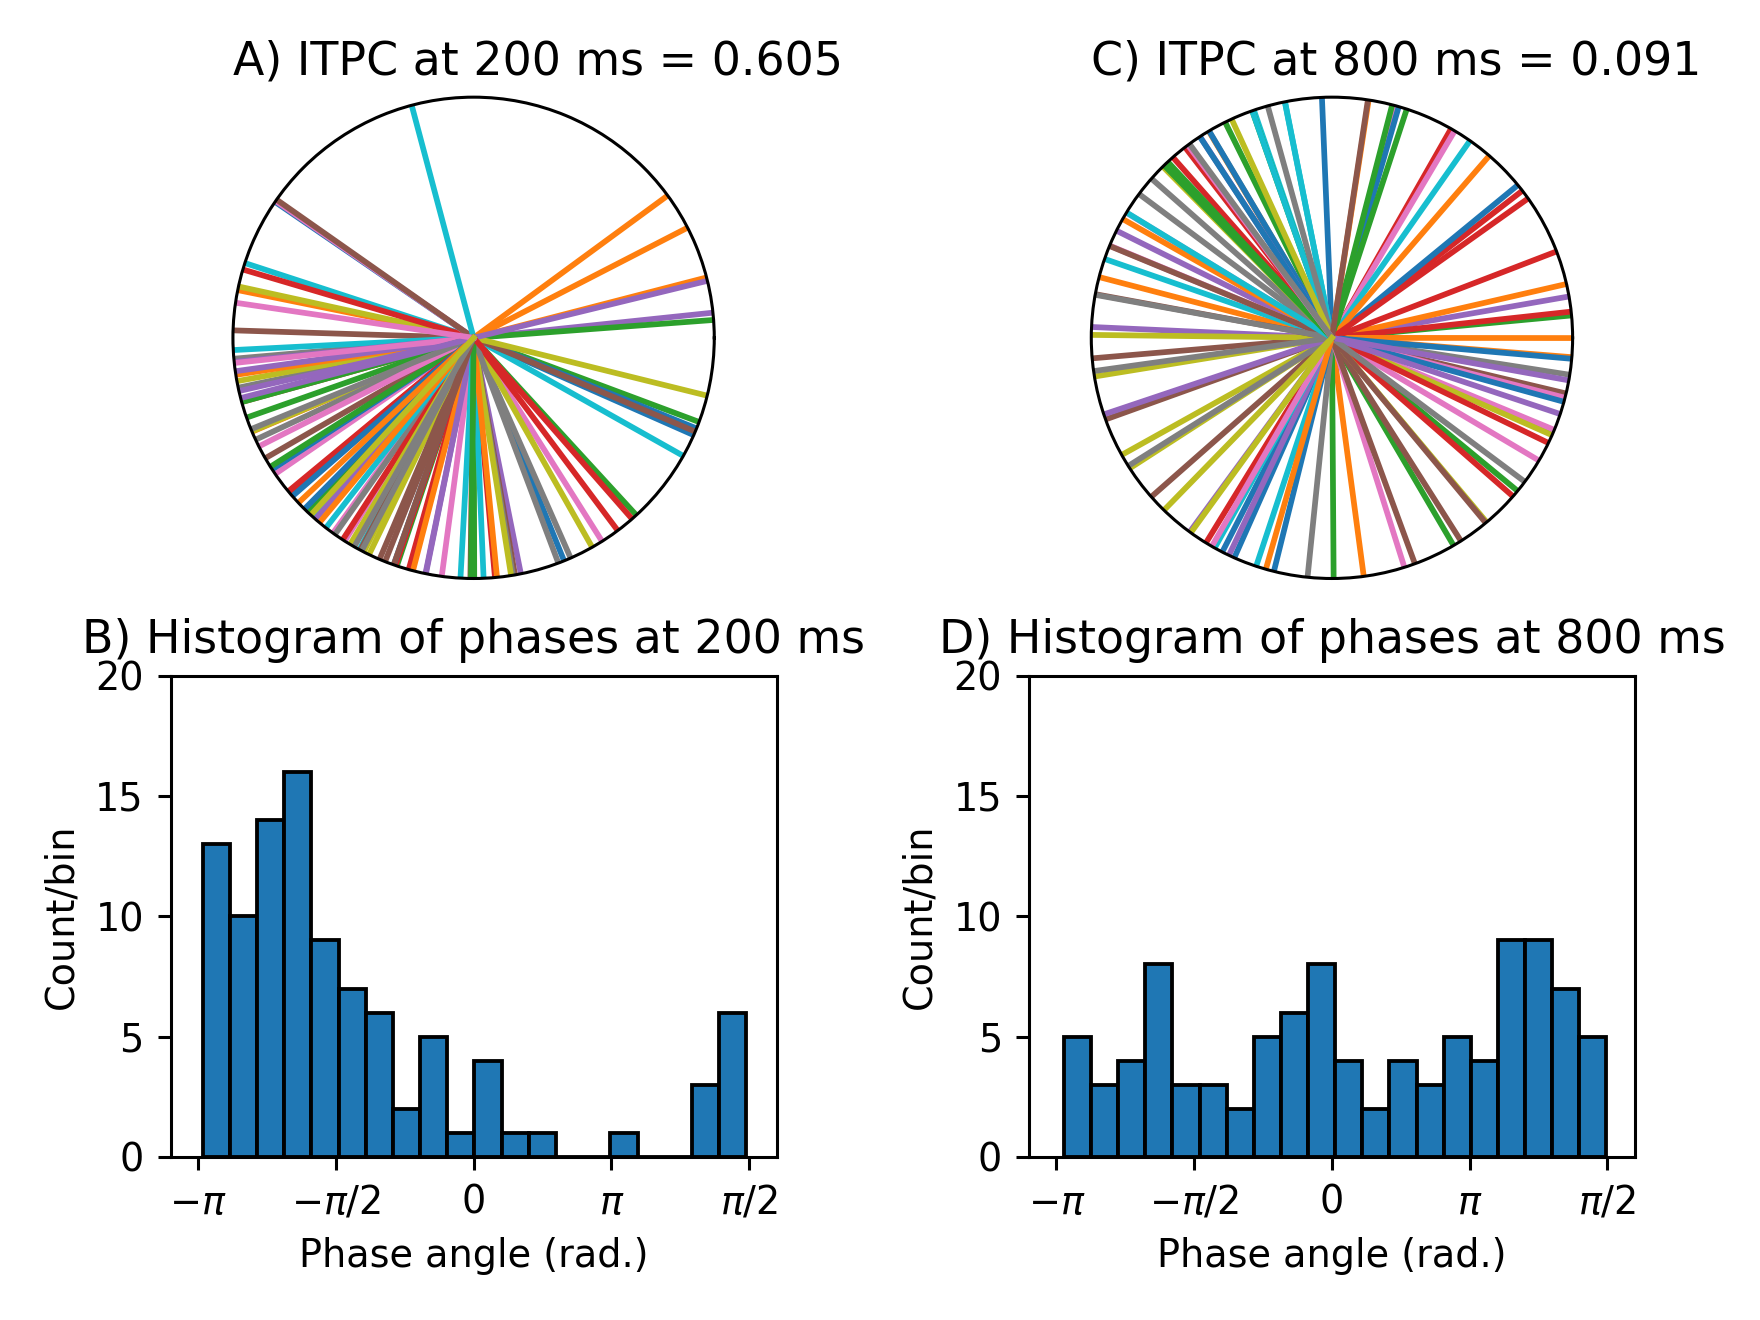

In [3]:
# Define center frequency and select channel
center_freq = 12 # Hz
chan_to_plot = 'Pz'
times_to_plot = [200, 800] # ms from stimulus onset

chan_idx = np.squeeze(np.where(np.array(chan_names) == chan_to_plot))

# Define convolution parameters
n_wavelet = np.shape(eeg_data)[1]
n_data = n_wavelet * np.shape(eeg_data)[2]
n_conv = n_wavelet + n_data - 1
n_conv_pow2 = pow(2, np.ceil(np.log2(np.abs(n_conv))))
time_param = n_wavelet / samp_rate / 2
n_cycle = 4

# Generate wavelet

# Note that the time vector to create the wavelet uses the same number of points 
# as there are in the EEG data. If the EEG data has an even number of points 
# (which is the case here--640), the wavelet will not have an exact center point. 
# Though not technically incorrect, using a wavelet with an even number of points 
# should be avoided when possible.
wavelet = get_sine_wave(center_freq, samp_rate, complex_wave=True,
              start_time=-time_param, end_time=time_param - (time_param / samp_rate)) * gauss_win(
                center_freq, samp_rate, n_cycle, normalize=True,
                start_time=-time_param, end_time=time_param - (time_param / samp_rate))

# Compute FFT on data
eeg_fft = np.fft.fft(np.reshape(eeg_data[chan_idx, :, :], n_data, order='F'), n_conv_pow2)

# Run the convolution
temp_conv = np.fft.ifft(np.fft.fft(wavelet, n_conv_pow2) * eeg_fft)[:n_conv]
eeg_conv = np.reshape(
    temp_conv[floor((n_wavelet - 1) / 2) - 1:len(temp_conv) - 1 - ceil((n_wavelet - 1) / 2)],
    [np.shape(eeg_data)[1], np.shape(eeg_data)[2]], order='F')

# For Figure 19.4
conv_copy = eeg_conv

fig = plt.figure()

for i in range(2):
    if i == 0:
        j = i
    else: 
        j += 2*i
    idx_obj = np.abs(eeg_time - times_to_plot[i])
    idx = np.where(idx_obj == np.min(idx_obj))
    
    ax0 = fig.add_subplot(2, 2, i + 1, projection='polar')
    ax0.plot(np.vstack([np.zeros([1, np.shape(eeg_data)[2]]), np.squeeze(np.angle(eeg_conv[idx, :]), axis=1)]), 
            np.vstack([np.zeros([1, np.shape(eeg_data)[2]]), np.ones([1, np.shape(eeg_data)[2]])]))
    ax0.set_xticks([])
    ax0.set_yticks([])
    ax0.set_ylim([0, 1])
    ax0.set_title(pos_to_char(j) + ') ITPC at ' + str(times_to_plot[i]) + ' ms = ' + str(
        np.round(1000 * np.abs(np.mean(np.exp(1j * np.angle(eeg_conv[idx, :])))))/1000),
                 loc = 'left')
    
    ax1 = fig.add_subplot(2, 2, i + 3)
    ax1.hist(np.squeeze(np.angle(eeg_conv[idx, :])), bins=20, edgecolor='black')
    ax1.set_xlim(np.array([-np.pi, np.pi]) * 1.1)
    ax1.set_ylim([0, 20])
    ax1.set_xticks(np.linspace(-np.pi, np.pi, 5))
    ax1.set_xticklabels([r'$-\pi$', r'$-\pi/2$', '0', r'$\pi$', r'$\pi/2$'])
    ax1.set_xlabel('Phase angle (rad.)')
    ax1.set_ylabel('Count/bin')
    ax1.set_title(pos_to_char(j + 1) + ') Histogram of phases at ' + str(times_to_plot[i]) + ' ms')

fig.tight_layout()

### Figure 19.3

Figure 19.3 shows example pairs of unit-length vectors and their averages (gray lines). The numbers inside each circle indicate the length of the average vector. This number is the ITPC for those two vectors

<IPython.core.display.Javascript object>


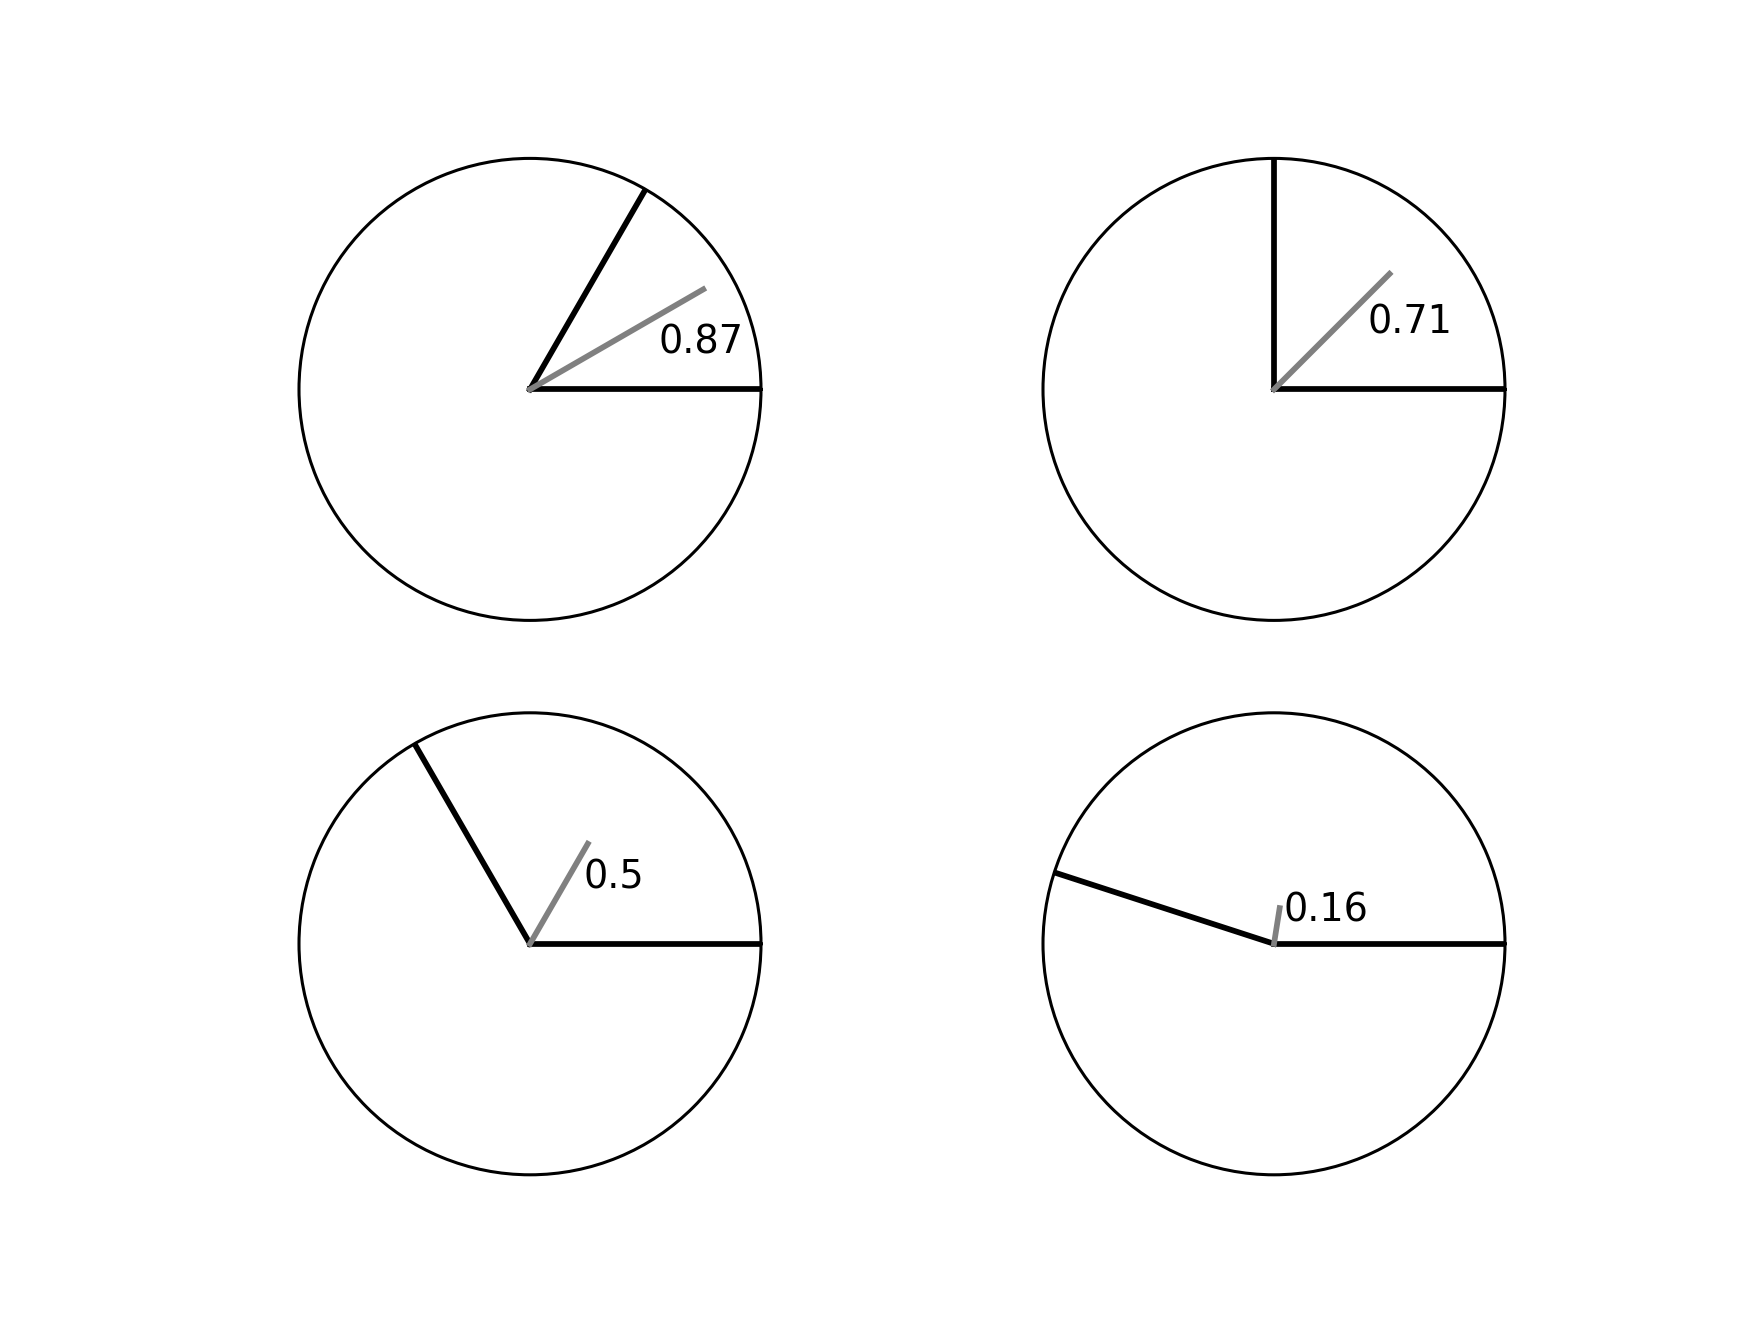

In [4]:
# Create four example vectors
vectors = np.array([
    [0, np.pi / 3],
    [0, np.pi / 2],
    [0, 2 * np.pi / 3],
    [0, np.pi * .9]
    ])

fig = plt.figure()

for i in range(len(vectors)):
    
    ax = fig.add_subplot(2, 2, i + 1, projection='polar')
    
    # Plot individual unit vectors
    ax.plot([0, vectors[i][0]], [0, 1], color='black')
    ax.plot([0, vectors[i][1]], [0, 1], color='black')
    
    # Plot the mean vector
    mean_vec = np.mean(np.exp(1j * vectors[i]))
    ax.plot([0, np.angle(mean_vec)], [0, np.abs(mean_vec)], color='grey')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_ylim([0, 1])
    ax.text(x=np.angle(mean_vec) - .25, y=np.abs(mean_vec) / 1.5, s=str(np.round(np.abs(mean_vec), 2)))

### Figure 19.4

Let $n$ be the number of trials, $k$ the phase angle, $r$ the trial number, $tf$ the time-frequency point:

Intertrial phase clustering (ITPC) in the time-frequency domain is defined as:

$$\textrm{ITPC}_{tf} = \mid n^{-1}\sum_{r=1}^n e^{ik_{tfr}}\mid$$

<IPython.core.display.Javascript object>


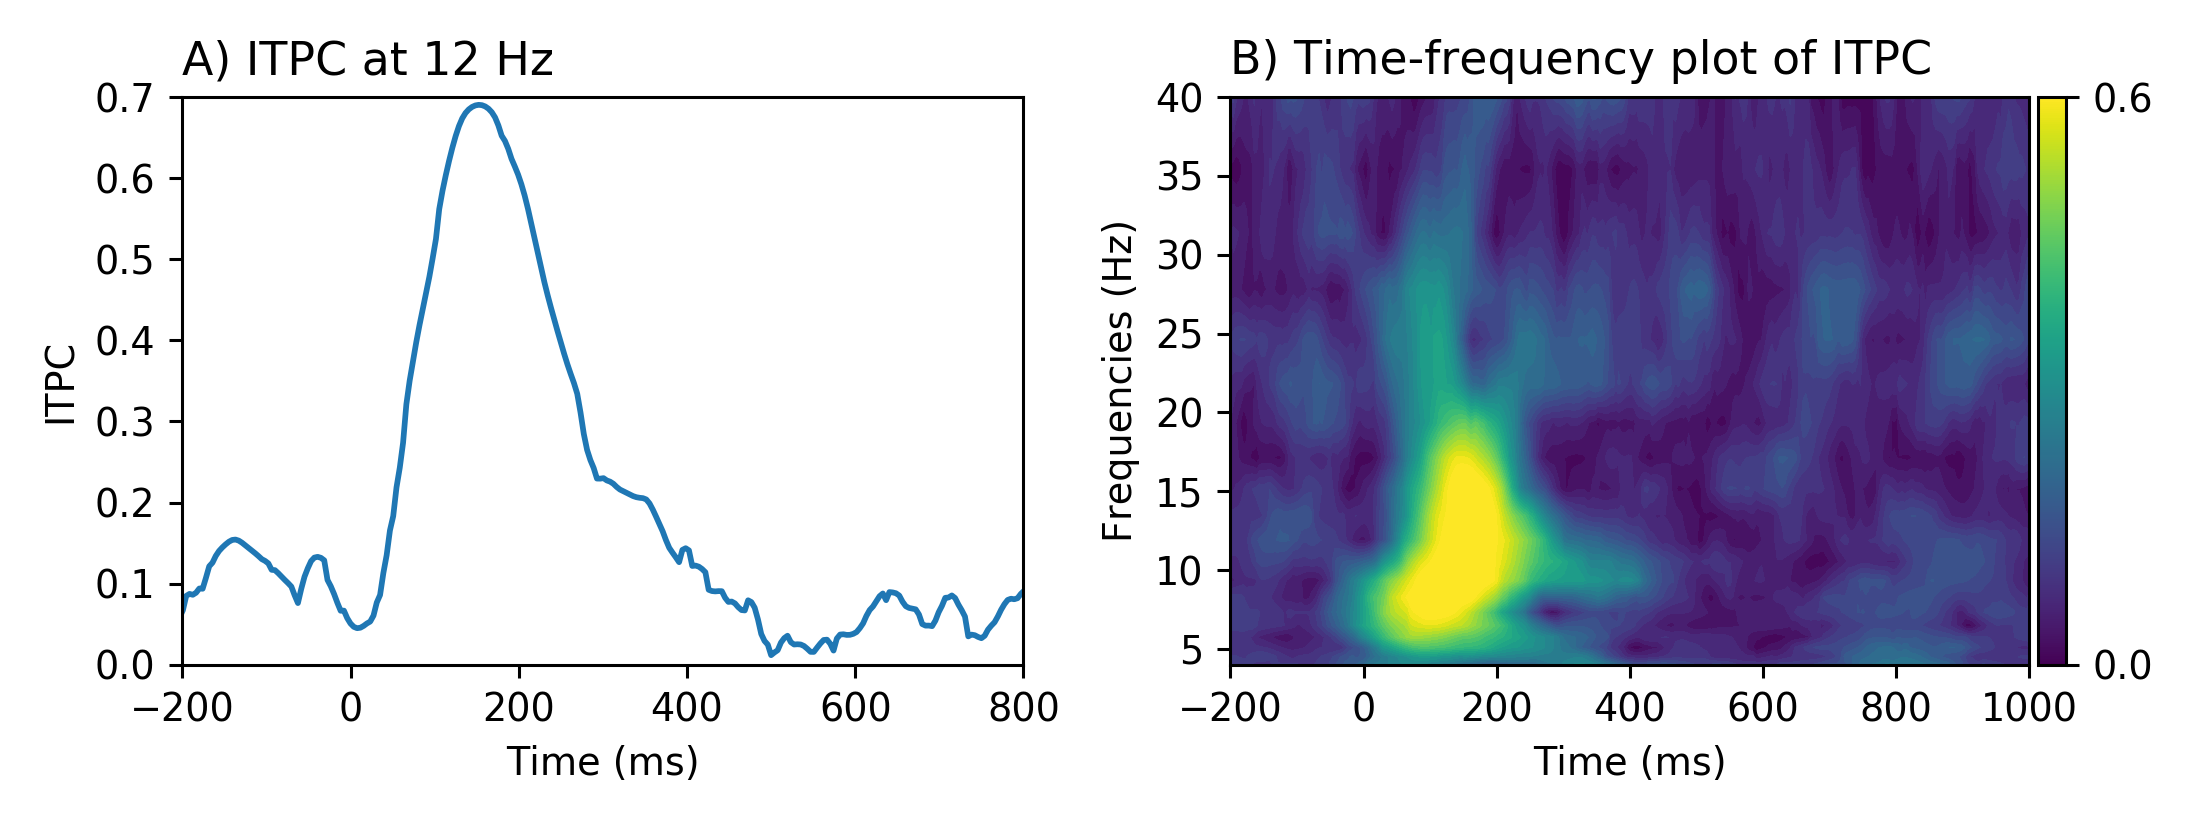

In [5]:
# Set parameters for ITPC
freqs = np.logspace(np.log10(4), np.log10(40), 20)
n_cycles = np.logspace(np.log10(3), np.log10(10), len(freqs))

# Initialize time-frequency output matrix
itpc = np.zeros([len(freqs), np.shape(eeg_data)[1]]);

# Compute ITPC at various frequencies
for i in range(len(freqs)):
    
    # Create wavelet
    wavelet = get_sine_wave(freqs[i], samp_rate, complex_wave=True,
        start_time=-time_param, end_time=time_param - (time_param / samp_rate)) * gauss_win(
        freqs[i], samp_rate, num_cycle=n_cycles[i], normalize=True,
        start_time=-time_param, end_time=time_param - (time_param / samp_rate))

    # Run the convolution
    temp_conv = np.fft.ifft(np.fft.fft(wavelet, n_conv_pow2) * eeg_fft)[:n_conv]
    eeg_conv = np.reshape(
        temp_conv[floor((n_wavelet - 1) / 2) - 1:len(temp_conv) - 1 - ceil((n_wavelet - 1) / 2)],
        [np.shape(eeg_data)[1], np.shape(eeg_data)[2]], order='F')
    
    # Extract and store ITPC
    itpc[i, :] = np.abs(np.mean(np.exp(1j * np.angle(eeg_conv)), 1))

# Plot center frequency and multiple frequencies
fig, ax = plt.subplots(figsize=(8, 3), ncols=2)

ax[0].plot(eeg_time, np.abs(np.mean(np.exp(1j * np.angle(conv_copy)), 1)))
ax[0].set_xlim([-200, 800])
ax[0].set_ylim([0, .7])
ax[0].set_xlabel('Time (ms)')
ax[0].set_ylabel('ITPC')
ax[0].set_title('A) ITPC at 12 Hz', loc='left')

ax[1].contourf(eeg_time, freqs, itpc, levels=40, vmin=0, vmax=.6)
ax[1].set_xlim([-200, 1000])
ax[1].set_yticks(np.linspace(5, 40, 8))
ax[1].set_xlabel('Time (ms)')
ax[1].set_ylabel('Frequencies (Hz)')
ax[1].set_title('B) Time-frequency plot of ITPC',loc='left')

m = plt.cm.ScalarMappable(norm=plt.Normalize(vmin=0, vmax=.6))
cbar = fig.colorbar(m, fraction=.04, pad=.01)
cbar.set_ticks([0, .6])

fig.tight_layout()

### Figure 19.5

<IPython.core.display.Javascript object>


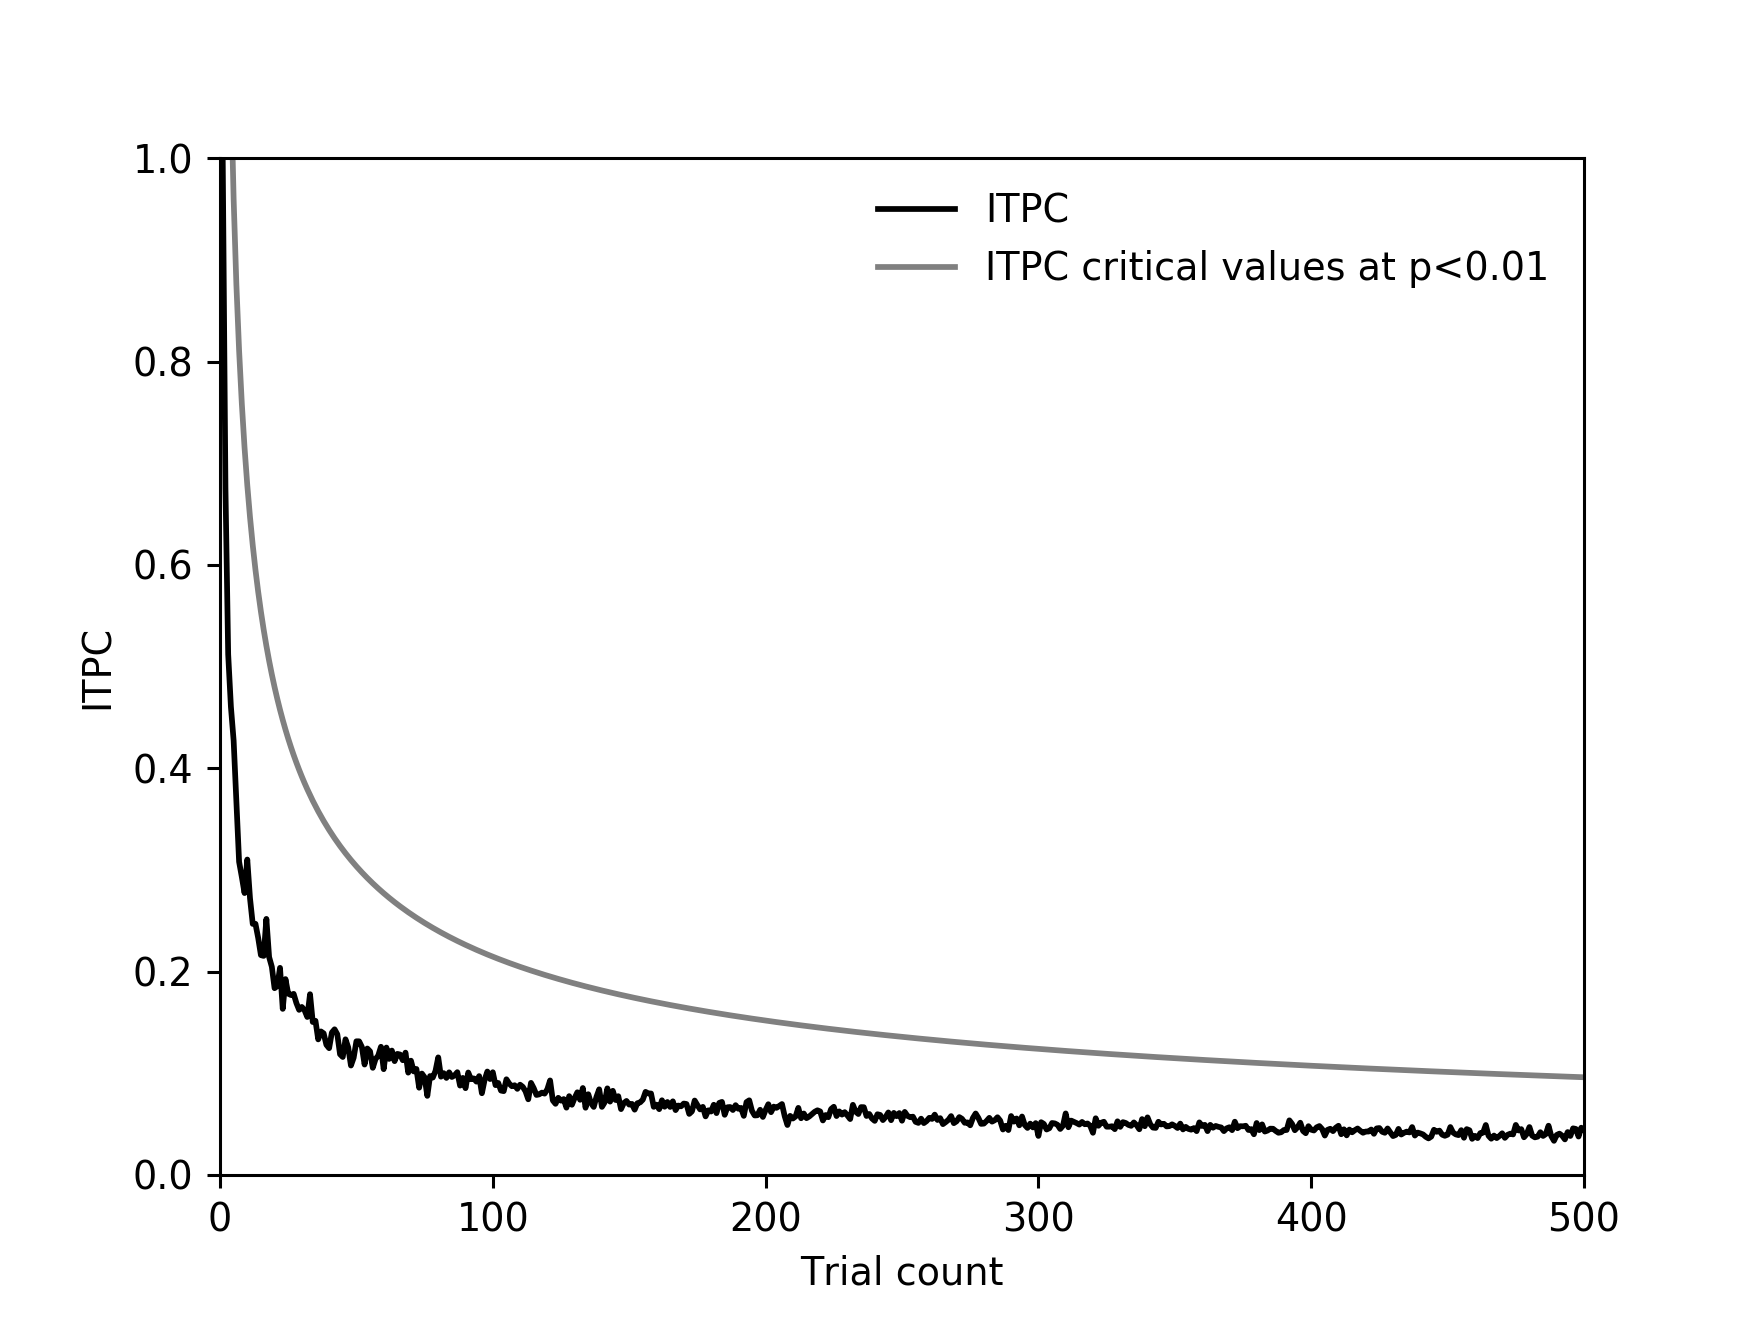

In [6]:
# Plot will be slightly different than text due to random-number generation

n_trials = 500
iters = 50
itpc_by_n = np.squeeze(np.zeros([1, n_trials]))

# Simulate random ITPC values
for i in range(n_trials):
    for j in range(iters):
        itpc_by_n[i] = itpc_by_n[i] + np.abs(np.mean(np.exp(
                1j * np.random.random([1, i + 1]) * 2 * np.pi - np.pi)))

sim_itpc_by_n = itpc_by_n / itpc_by_n[0]

# Compute Z and p (Formulas located in chapter 34)
trials = np.arange(1, n_trials + 1)
sim_z = trials * sim_itpc_by_n ** 2
sim_p = np.exp(np.sqrt(1 + 4 * trials + 4 * (trials ** 2) - (trials ** sim_itpc_by_n) ** 2) - (1 + 2 * trials))
sim_crit = np.sqrt(-np.log(.01) / trials) # .01 = p-value

plt.figure()

plt.plot(trials, sim_itpc_by_n, color='black')
plt.plot(trials, sim_crit, color='grey')
plt.xlim([0, 500])
plt.ylim([0, 1])
plt.xlabel('Trial count')
plt.ylabel('ITPC')
plt.legend(['ITPC', 'ITPC critical values at p<0.01'], frameon=False)

plt.show()

### Figure 19.6

<IPython.core.display.Javascript object>


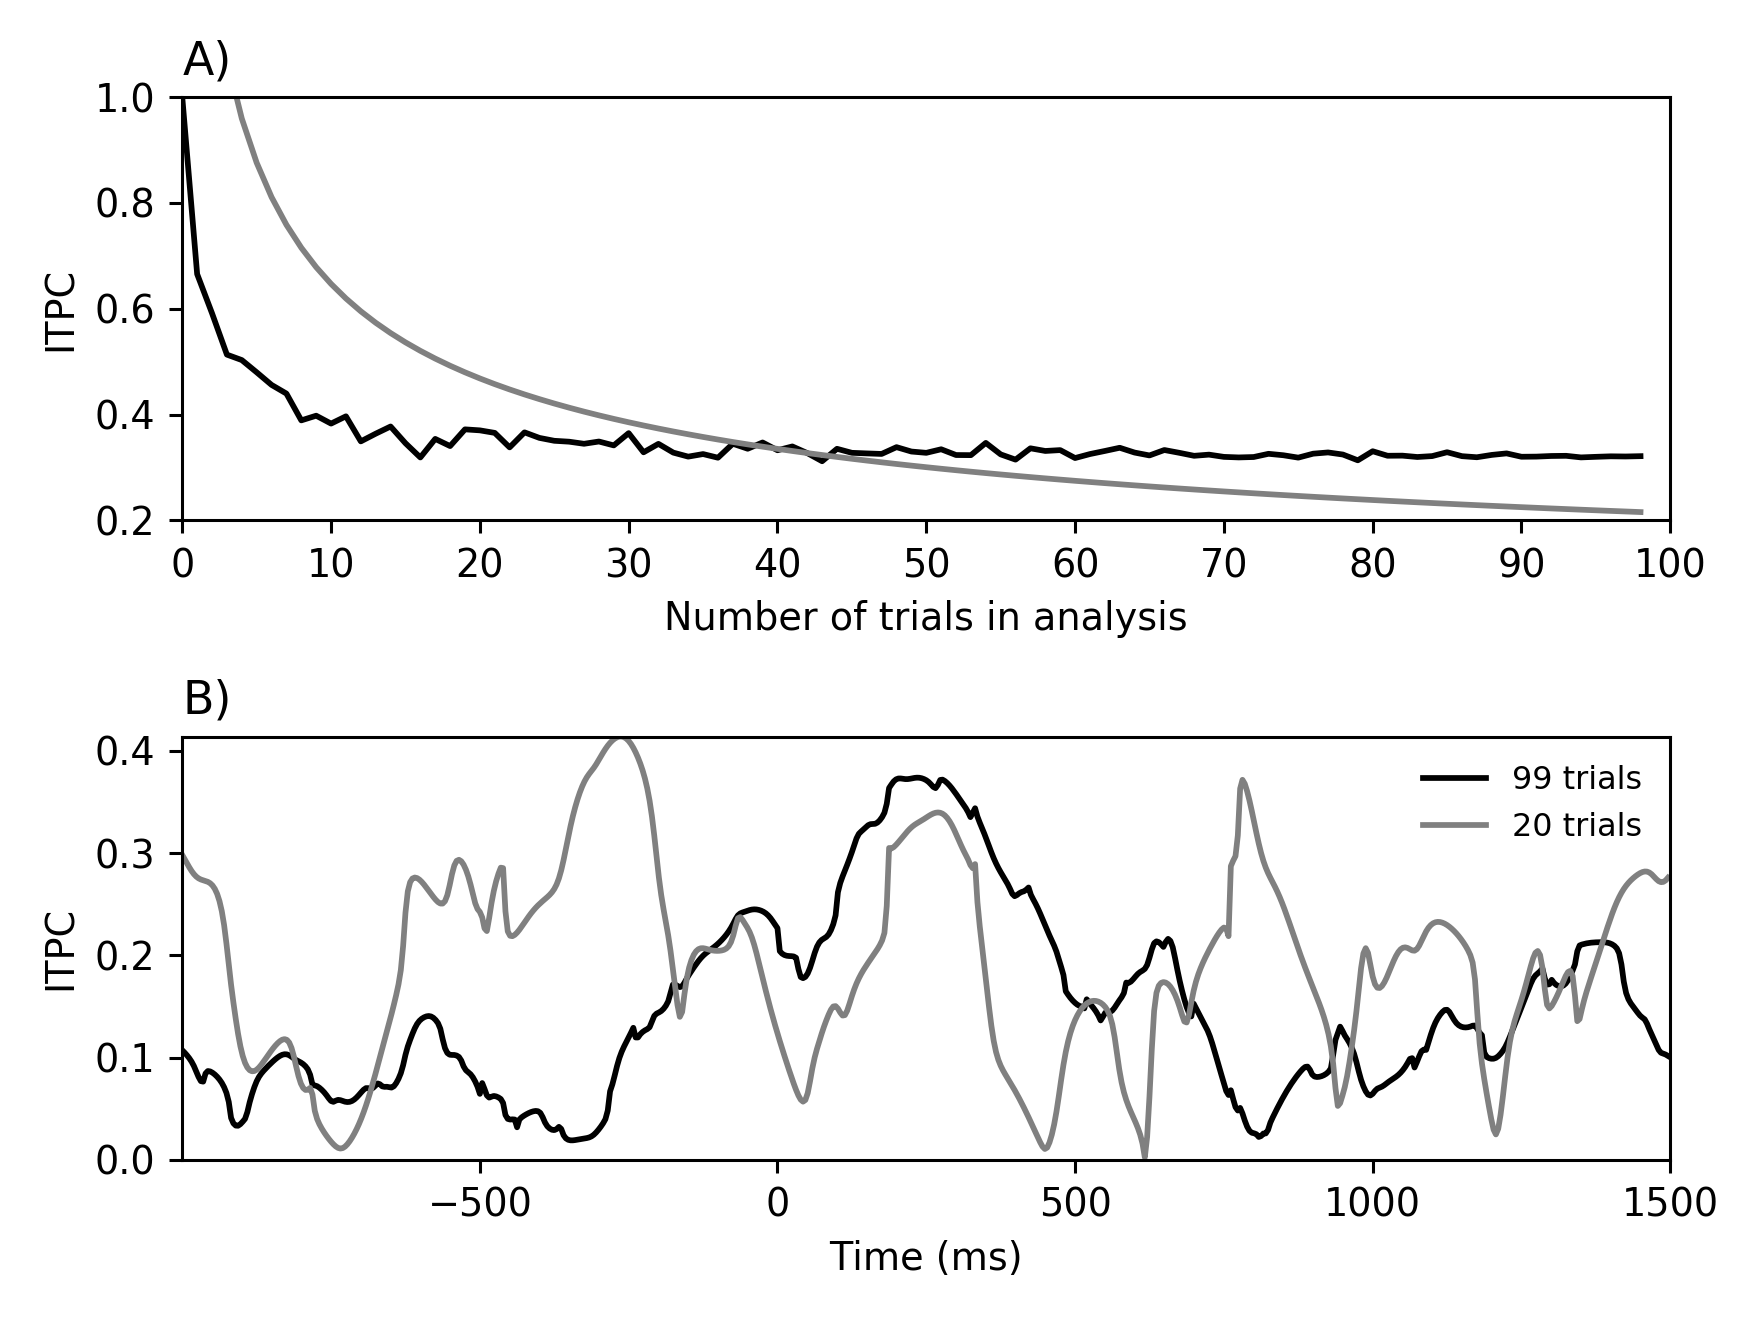

In [7]:
# Plot will be slightly different than text due to random-number generation

# Define center frequency and select channel
center_freq = 6 # Hz
chan_to_plot = 'FCz'
chan_idx = np.squeeze(np.where(np.array(chan_names) == chan_to_plot))

# Compute wavelet
wavelet = get_sine_wave(center_freq, samp_rate, complex_wave=True,
              start_time=-time_param, end_time=time_param - (time_param / samp_rate)) * gauss_win(
                center_freq, samp_rate, n_cycle, normalize=True,
                start_time=-time_param, end_time=time_param - (time_param / samp_rate))

# Compute FFT on data
eeg_fft = np.fft.fft(np.reshape(eeg_data[chan_idx, :, :], n_data, order='F'), n_conv_pow2)

# Run the convolution
temp_conv = np.fft.ifft(np.fft.fft(wavelet, n_conv_pow2) * eeg_fft)[:n_conv]
eeg_conv = np.reshape(
    temp_conv[floor((n_wavelet - 1) / 2) - 1:len(temp_conv) - 1 - ceil((n_wavelet - 1) / 2)],
    [np.shape(eeg_data)[1], np.shape(eeg_data)[2]], order='F')

# Compute ITPC as function of the number of trials
itpc_by_n = np.squeeze(np.zeros([1, np.shape(eeg_data)[2]]))

for i in range(len(itpc_by_n)):
    # Multiple iterations to select different sets of random trials
    for j in range(iters):
        trials_to_use = np.random.choice(np.shape(eeg_data)[2], i + 1, replace=False)
        itpc_by_n[i] = itpc_by_n[i] + np.mean(np.abs(np.mean(np.exp(
                1j * np.angle(eeg_conv[281:372, trials_to_use])), 1)), 0)

eeg_itpc_by_n = itpc_by_n / iters

# Compute Z and p (Formulas located in chapter 34)
trials = np.arange(1, np.shape(eeg_data)[2] + 1)
eeg_z = trials * eeg_itpc_by_n ** 2
eeg_p = np.exp(np.sqrt(1 + 4 * trials + 4 * (trials ** 2) - (trials ** eeg_itpc_by_n) ** 2) - (1 + 2 * trials))
eeg_crit = np.sqrt(-np.log(.01) / trials) # .01 = p-value

# Plot the results

fig, ax = plt.subplots(nrows=2)

ax[0].plot(eeg_itpc_by_n, color='black')
ax[0].plot(eeg_crit, color='grey')
ax[0].set_xlim([0, 100])
ax[0].set_ylim([.2, 1])
ax[0].set_xticks(np.linspace(0, 100, 11))
ax[0].set_xlabel('Number of trials in analysis')
ax[0].set_ylabel('ITPC')
ax[0].set_title('A)', loc='left')

rand_trials = np.random.permutation(np.shape(eeg_data)[2])
rand_itpc = np.abs(np.mean(np.exp(1j * np.angle(eeg_conv[:, rand_trials[:20]])), 1))
ax[1].plot(eeg_time, np.abs(np.mean(np.exp(1j * np.angle(eeg_conv)), 1)), color='black')
ax[1].plot(eeg_time, rand_itpc, color='grey')
ax[1].set_xlim([-1000, 1500])
ax[1].set_ylim([0, np.max(rand_itpc)])
ax[1].set_xticks(np.linspace(-500, 1500, 5))
ax[1].set_xlabel('Time (ms)')
ax[1].set_ylabel('ITPC')
ax[1].set_title('B)', loc='left')
ax[1].legend(['99 trials', '20 trials'], fontsize='small', frameon=False)

fig.tight_layout()

### Figure 19.7

<IPython.core.display.Javascript object>


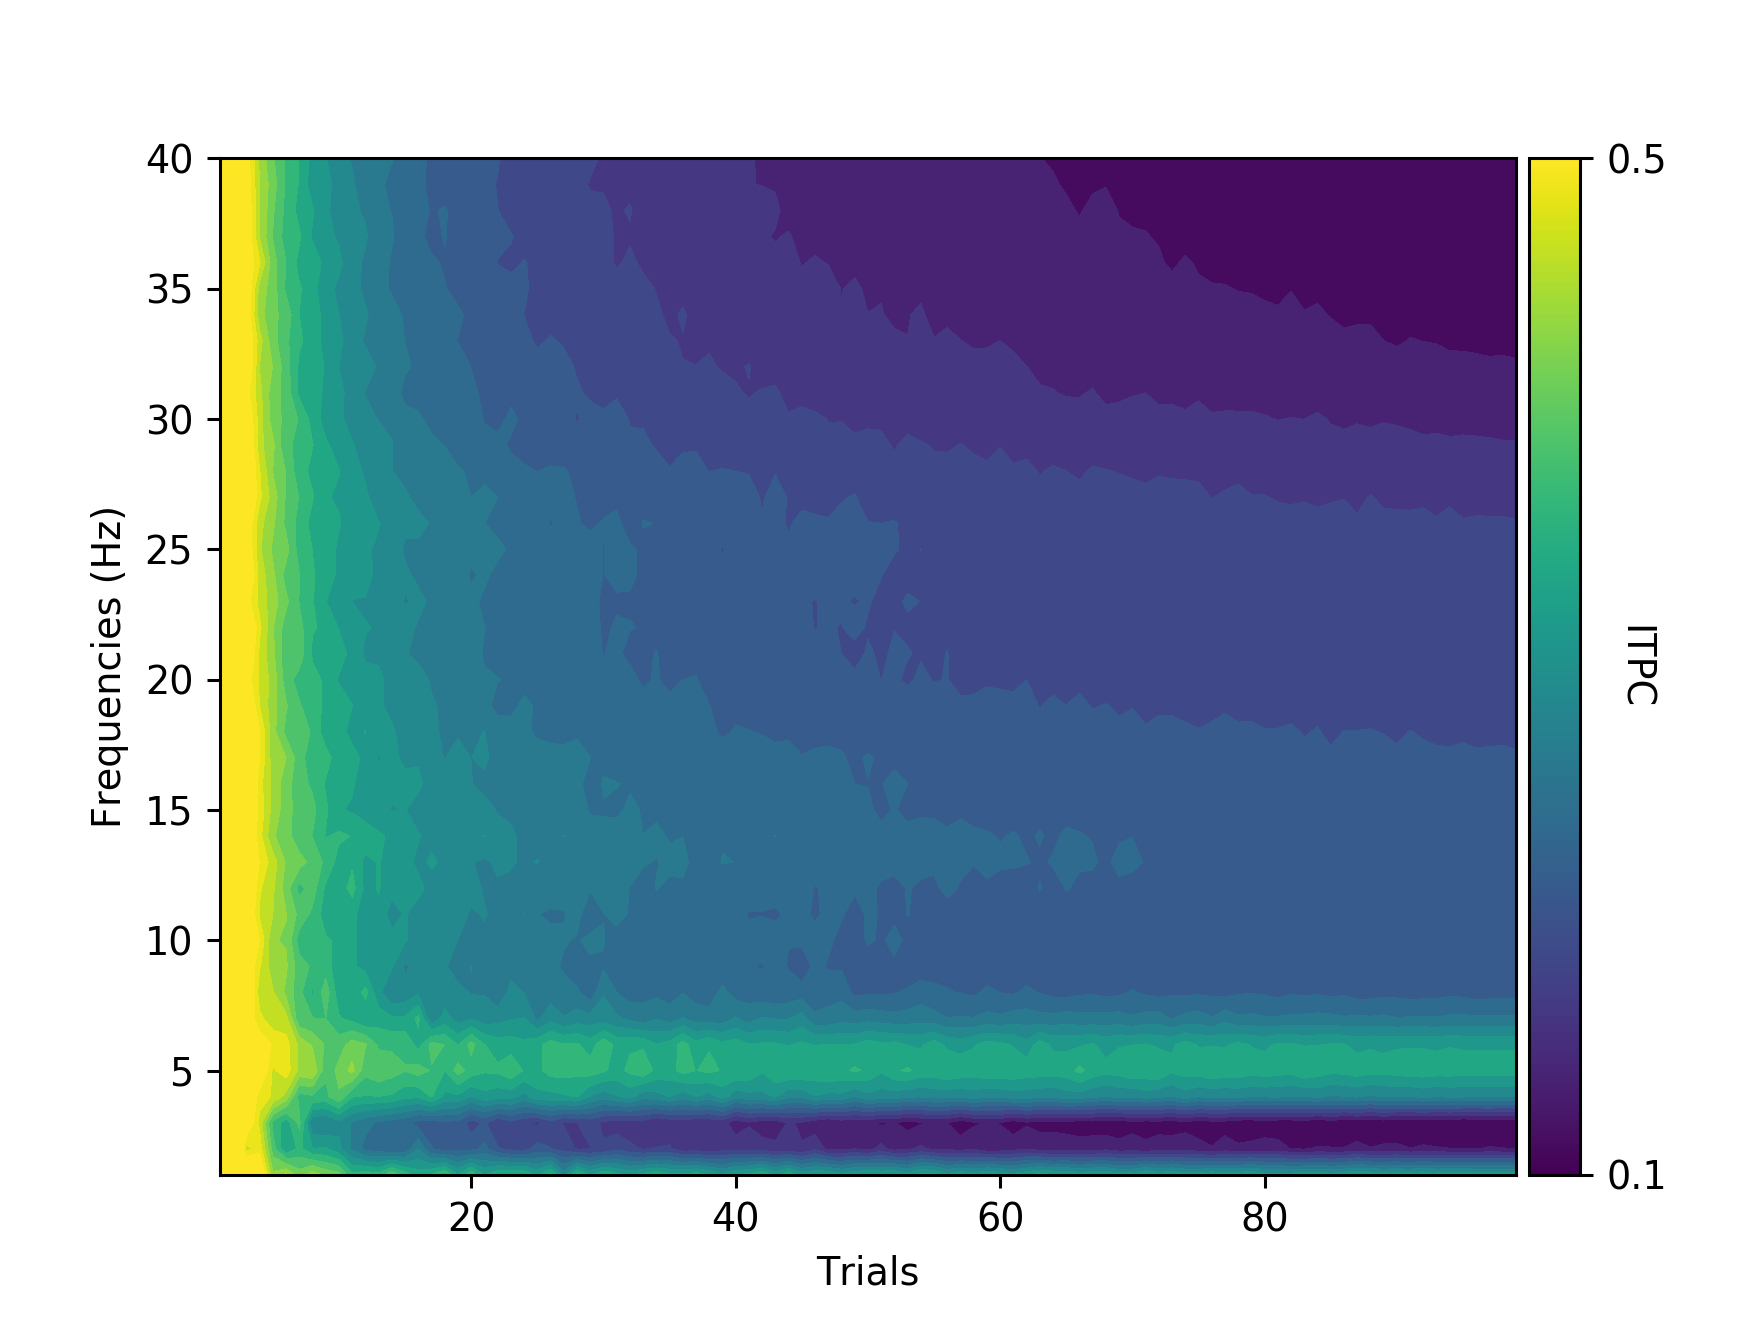

In [8]:
# Define center frequencies
freqs = np.arange(1, 41) # Hz

# Initialize time-frequency output matrix
itpc_by_n_and_f = np.zeros([len(freqs), np.shape(eeg_data)[2]])

for i in range(len(freqs)):
    center_freq = freqs[i]

    # Compute wavelet
    wavelet = get_sine_wave(center_freq, samp_rate, complex_wave=True,
                  start_time=-time_param, end_time=time_param - (time_param / samp_rate)) * gauss_win(
                    center_freq, samp_rate, n_cycle, normalize=True,
                    start_time=-time_param, end_time=time_param - (time_param / samp_rate))

    # Compute FFT on data
    eeg_fft = np.fft.fft(np.reshape(eeg_data[chan_idx, :, :], n_data, order='F'), n_conv_pow2)

    # Run the convolution
    temp_conv = np.fft.ifft(np.fft.fft(wavelet, n_conv_pow2) * eeg_fft)[:n_conv]
    eeg_conv = np.reshape(
        temp_conv[floor((n_wavelet - 1) / 2) - 1:len(temp_conv) - 1 - ceil((n_wavelet - 1) / 2)],
        [np.shape(eeg_data)[1], np.shape(eeg_data)[2]], order='F')
    
    for j in range(np.shape(eeg_data)[2]):
        for k in range(iters):
            # Multiple iterations to select different sets of random trials
            trials_to_use = np.random.choice(np.shape(eeg_data)[2], j + 1, replace=False)
            itpc_by_n_and_f[i, j] = itpc_by_n_and_f[i, j] + np.mean(np.abs(np.mean(np.exp(
                1j * np.angle(eeg_conv[281:372, trials_to_use])), 1)), 0)
            
fig = plt.figure()

plt.contourf(trials, freqs, itpc_by_n_and_f / iters, levels=40, vmin=.1, vmax=.5)
plt.xlim([1, 99])
plt.yticks(np.linspace(5, 40, 8))
plt.xlabel('Trials')
plt.ylabel('Frequencies (Hz)')

m = plt.cm.ScalarMappable(norm=plt.Normalize(vmin=.1, vmax=.5))
cbar = fig.colorbar(m, fraction=.04, pad=.01)
cbar.set_ticks([.1, .5])
cbar.set_label('ITPC', rotation=270, labelpad=-4)

plt.show()

### Figure 19.8

Rayleigh's Z ($\textrm{ITPC}_{Z}$) is defined as:

$$\textrm{ITPC}_{Z} = n * \textrm{ITPC}^2$$

<IPython.core.display.Javascript object>


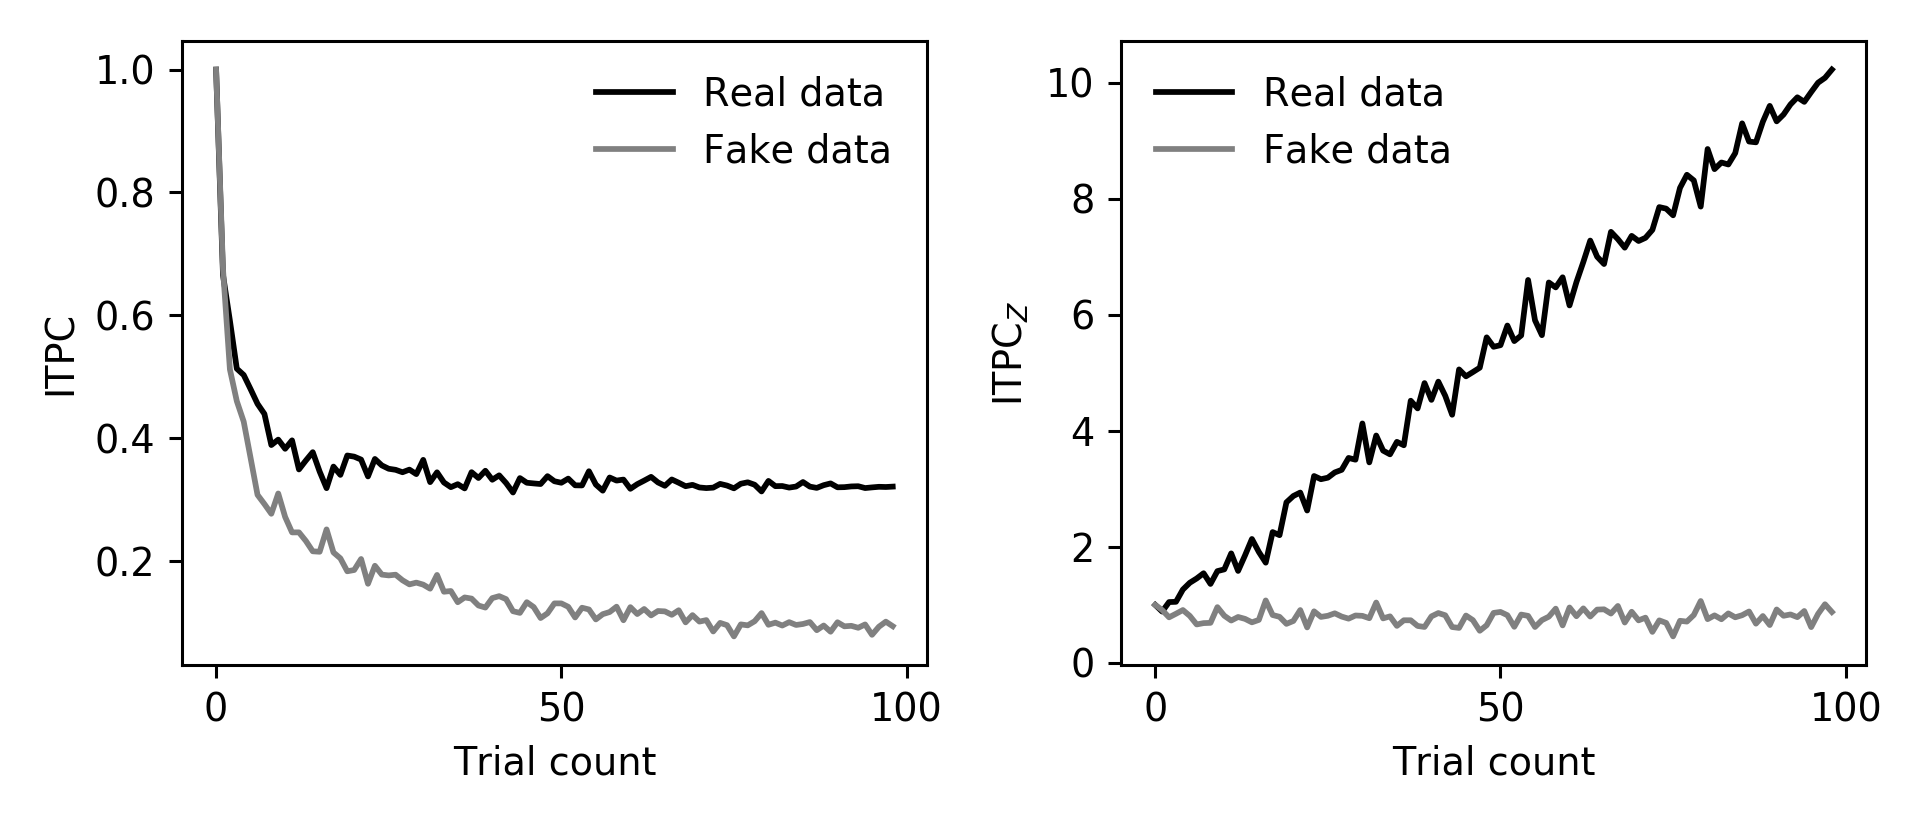

In [9]:
# Plot will be slightly different than text due to random-number generation

fig, ax = plt.subplots(figsize=(7, 3), ncols=2, sharex=True)

y_labs = ['ITPC', r'ITPC$_{Z}$']
eeg_plot = [eeg_itpc_by_n, eeg_z]
sim_plot = [sim_itpc_by_n, sim_z]

for i in range(len(ax)):
    ax[i].plot(eeg_plot[i], color='black')
    ax[i].plot(sim_plot[i][:99], color='grey')
    ax[i].set_xticks(np.linspace(0, 100, 3))
    ax[i].set_xlabel('Trial count')
    ax[i].set_ylabel(y_labs[i])
    ax[i].legend(['Real data', 'Fake data'], frameon=False)

fig.tight_layout()

### Figure 19.9

<IPython.core.display.Javascript object>


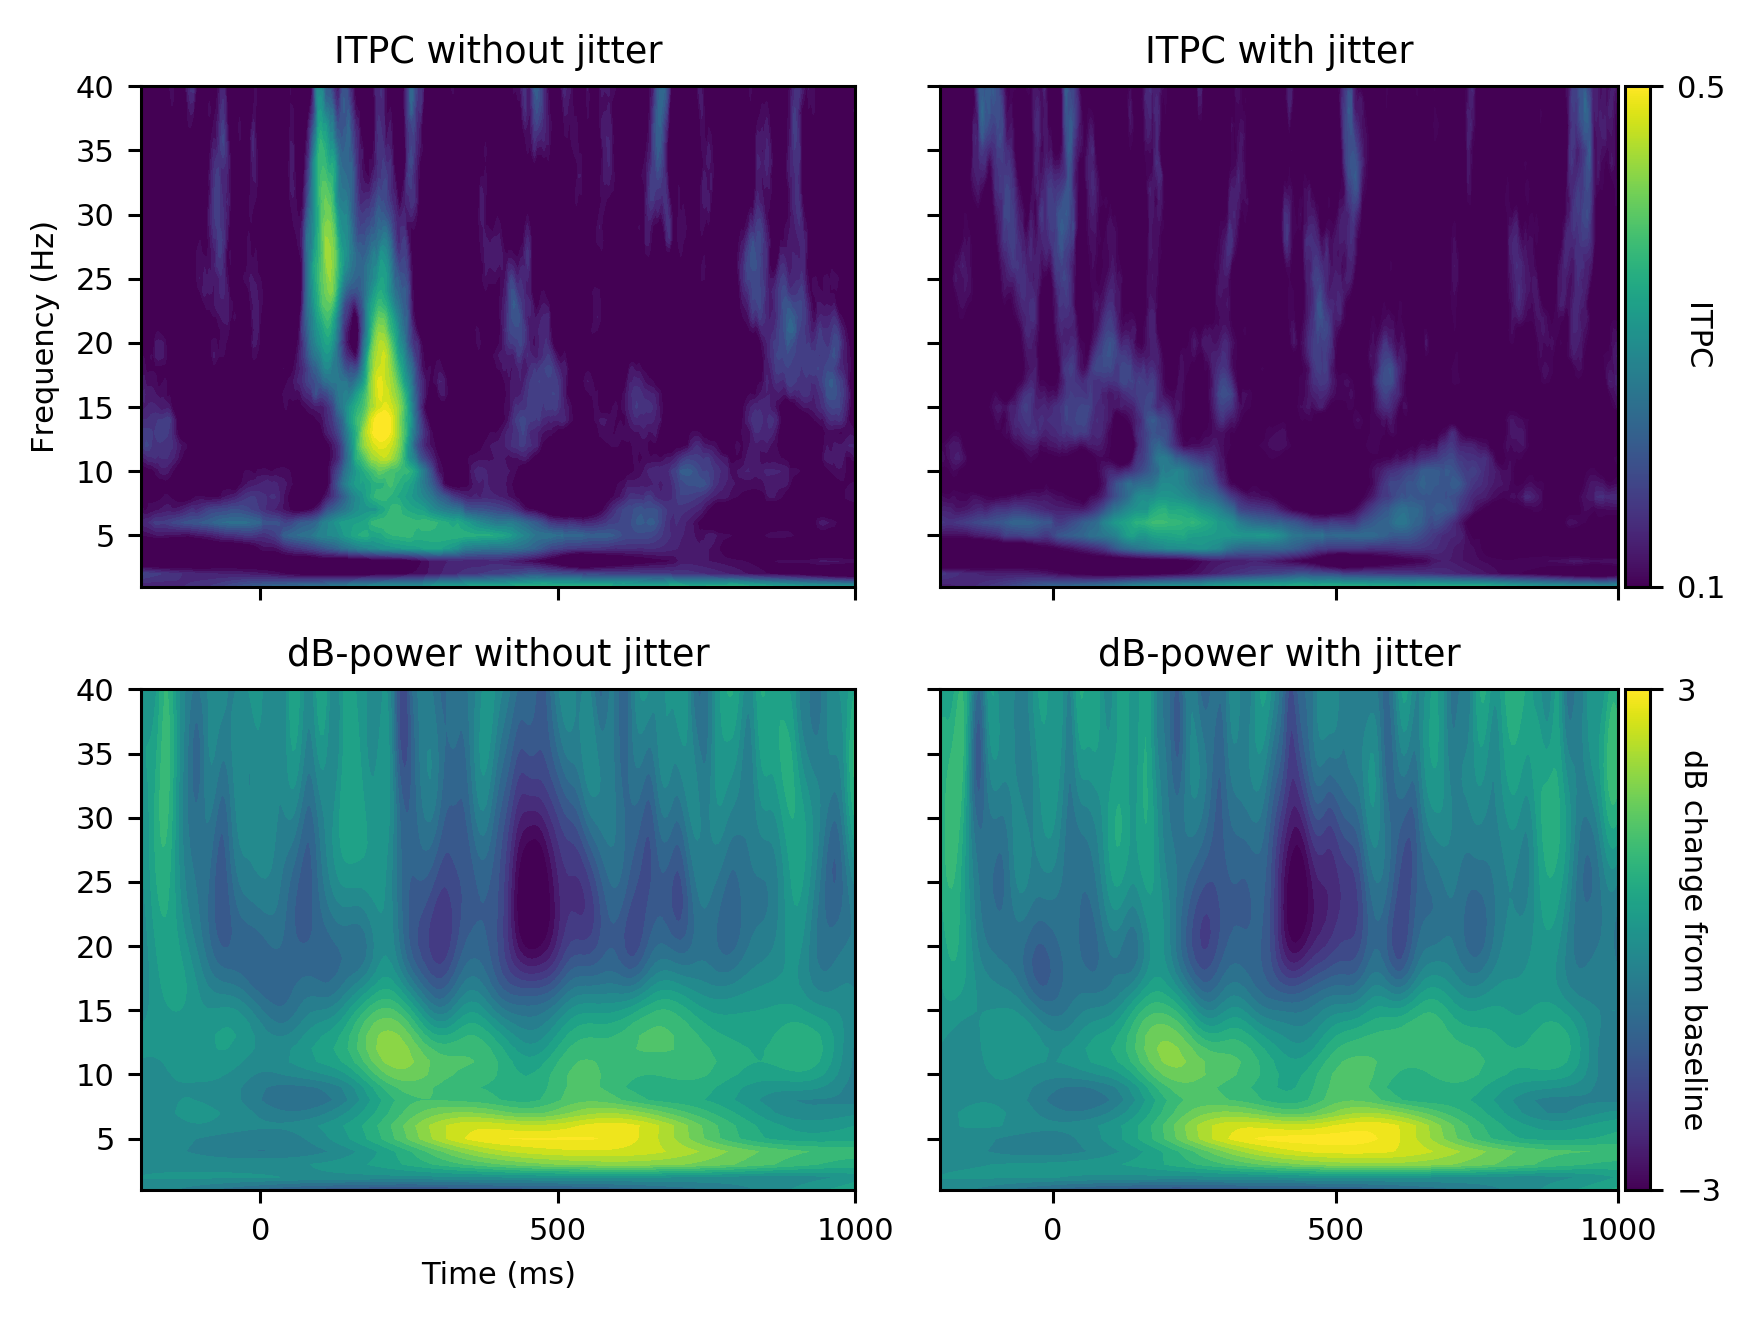

In [10]:
# Plot will be slightly different than text due to random-number generation

plt.rc('font', size=8)

fig, ax = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True)

title_labs = ['without jitter', 'with jitter']
baseline = [-300, -100]
dsearch = find_nearest(eeg_time, baseline)
base_idx = np.arange(dsearch[0], dsearch[1] + 1)

for i in range(2):
    
    # Add time jitter (or not)
    temp_dat = eeg_data[chan_idx, :, :]
    
    for j in range(np.shape(temp_dat)[1]):
        time_jitter = ceil(np.random.random(1) * 10) * i # No time jitter on first iteration of i
        temp_dat[:, j] = np.hstack([temp_dat[time_jitter:, j], temp_dat[:time_jitter, j]])
        
    # Compute FFT on data
    eeg_fft = np.fft.fft(np.reshape(temp_dat, 
        np.shape(temp_dat)[0] * np.shape(temp_dat)[1], order='F'), n_conv_pow2)
    
    # Initialize output
    itpc = np.zeros([len(freqs), np.shape(eeg_data)[1]])
    temp_power = itpc.copy()
    power = temp_power.copy()
    
    for j in range(len(freqs)):
        center_freq = freqs[j]

        # Compute wavelet
        wavelet = get_sine_wave(center_freq, samp_rate, complex_wave=True,
                      start_time=-time_param, end_time=time_param - (time_param / samp_rate)) * gauss_win(
                        center_freq, samp_rate, n_cycle, normalize=True,
                        start_time=-time_param, end_time=time_param - (time_param / samp_rate))

        # Run the convolution
        temp_conv = np.fft.ifft(np.fft.fft(wavelet, n_conv_pow2) * eeg_fft)[:n_conv]
        eeg_conv = np.reshape(
            temp_conv[floor((n_wavelet - 1) / 2) - 1:len(temp_conv) - 1 - ceil((n_wavelet - 1) / 2)],
            [np.shape(eeg_data)[1], np.shape(eeg_data)[2]], order='F')
        
        # Extract and store ITPC and power
        itpc[j, :] = np.abs(np.mean(np.exp(1j * np.angle(eeg_conv)), 1))
        temp_power[j, :] = np.mean(np.abs(eeg_conv) ** 2, 1)
        power[j, :] = 10 * np.log10(temp_power[j, :] / np.mean(temp_power[j, base_idx]))
        
    ax[0, i].contourf(eeg_time, freqs, itpc, levels=40, vmin=.1, vmax=.5)
    ax[0, i].set_title('ITPC ' + title_labs[i])
    
    ax[1, i].contourf(eeg_time, freqs, power, levels=40, vmin=-3, vmax=3)
    ax[1, i].set_title('dB-power ' + title_labs[i])
    
    if i == 1:
        m1 = plt.cm.ScalarMappable(norm=plt.Normalize(vmin=.1, vmax=.5))
        cbar1 = fig.colorbar(m1, ax=ax[0, i], fraction=.04, pad=.01)
        cbar1.set_ticks([.1, .5])
        cbar1.set_label('ITPC', rotation=270, labelpad=-4)
        
        m2 = plt.cm.ScalarMappable(norm=plt.Normalize(vmin=-3, vmax=3))
        cbar2 = fig.colorbar(m2, ax=ax[1, i], fraction=.04, pad=.01)
        cbar2.set_ticks([-3, 3])
        cbar2.set_label('dB change from baseline', rotation=270, labelpad=-4)
    else:
        ax[0, i].set_xlim([-200, 1000])
        ax[0, i].set_xticks(np.linspace(0, 1000, 3))
        ax[0, i].set_ylabel('Frequency (Hz)')
        ax[1, i].set_xlabel('Time (ms)')

fig.tight_layout()

### Figure 19.10

<IPython.core.display.Javascript object>


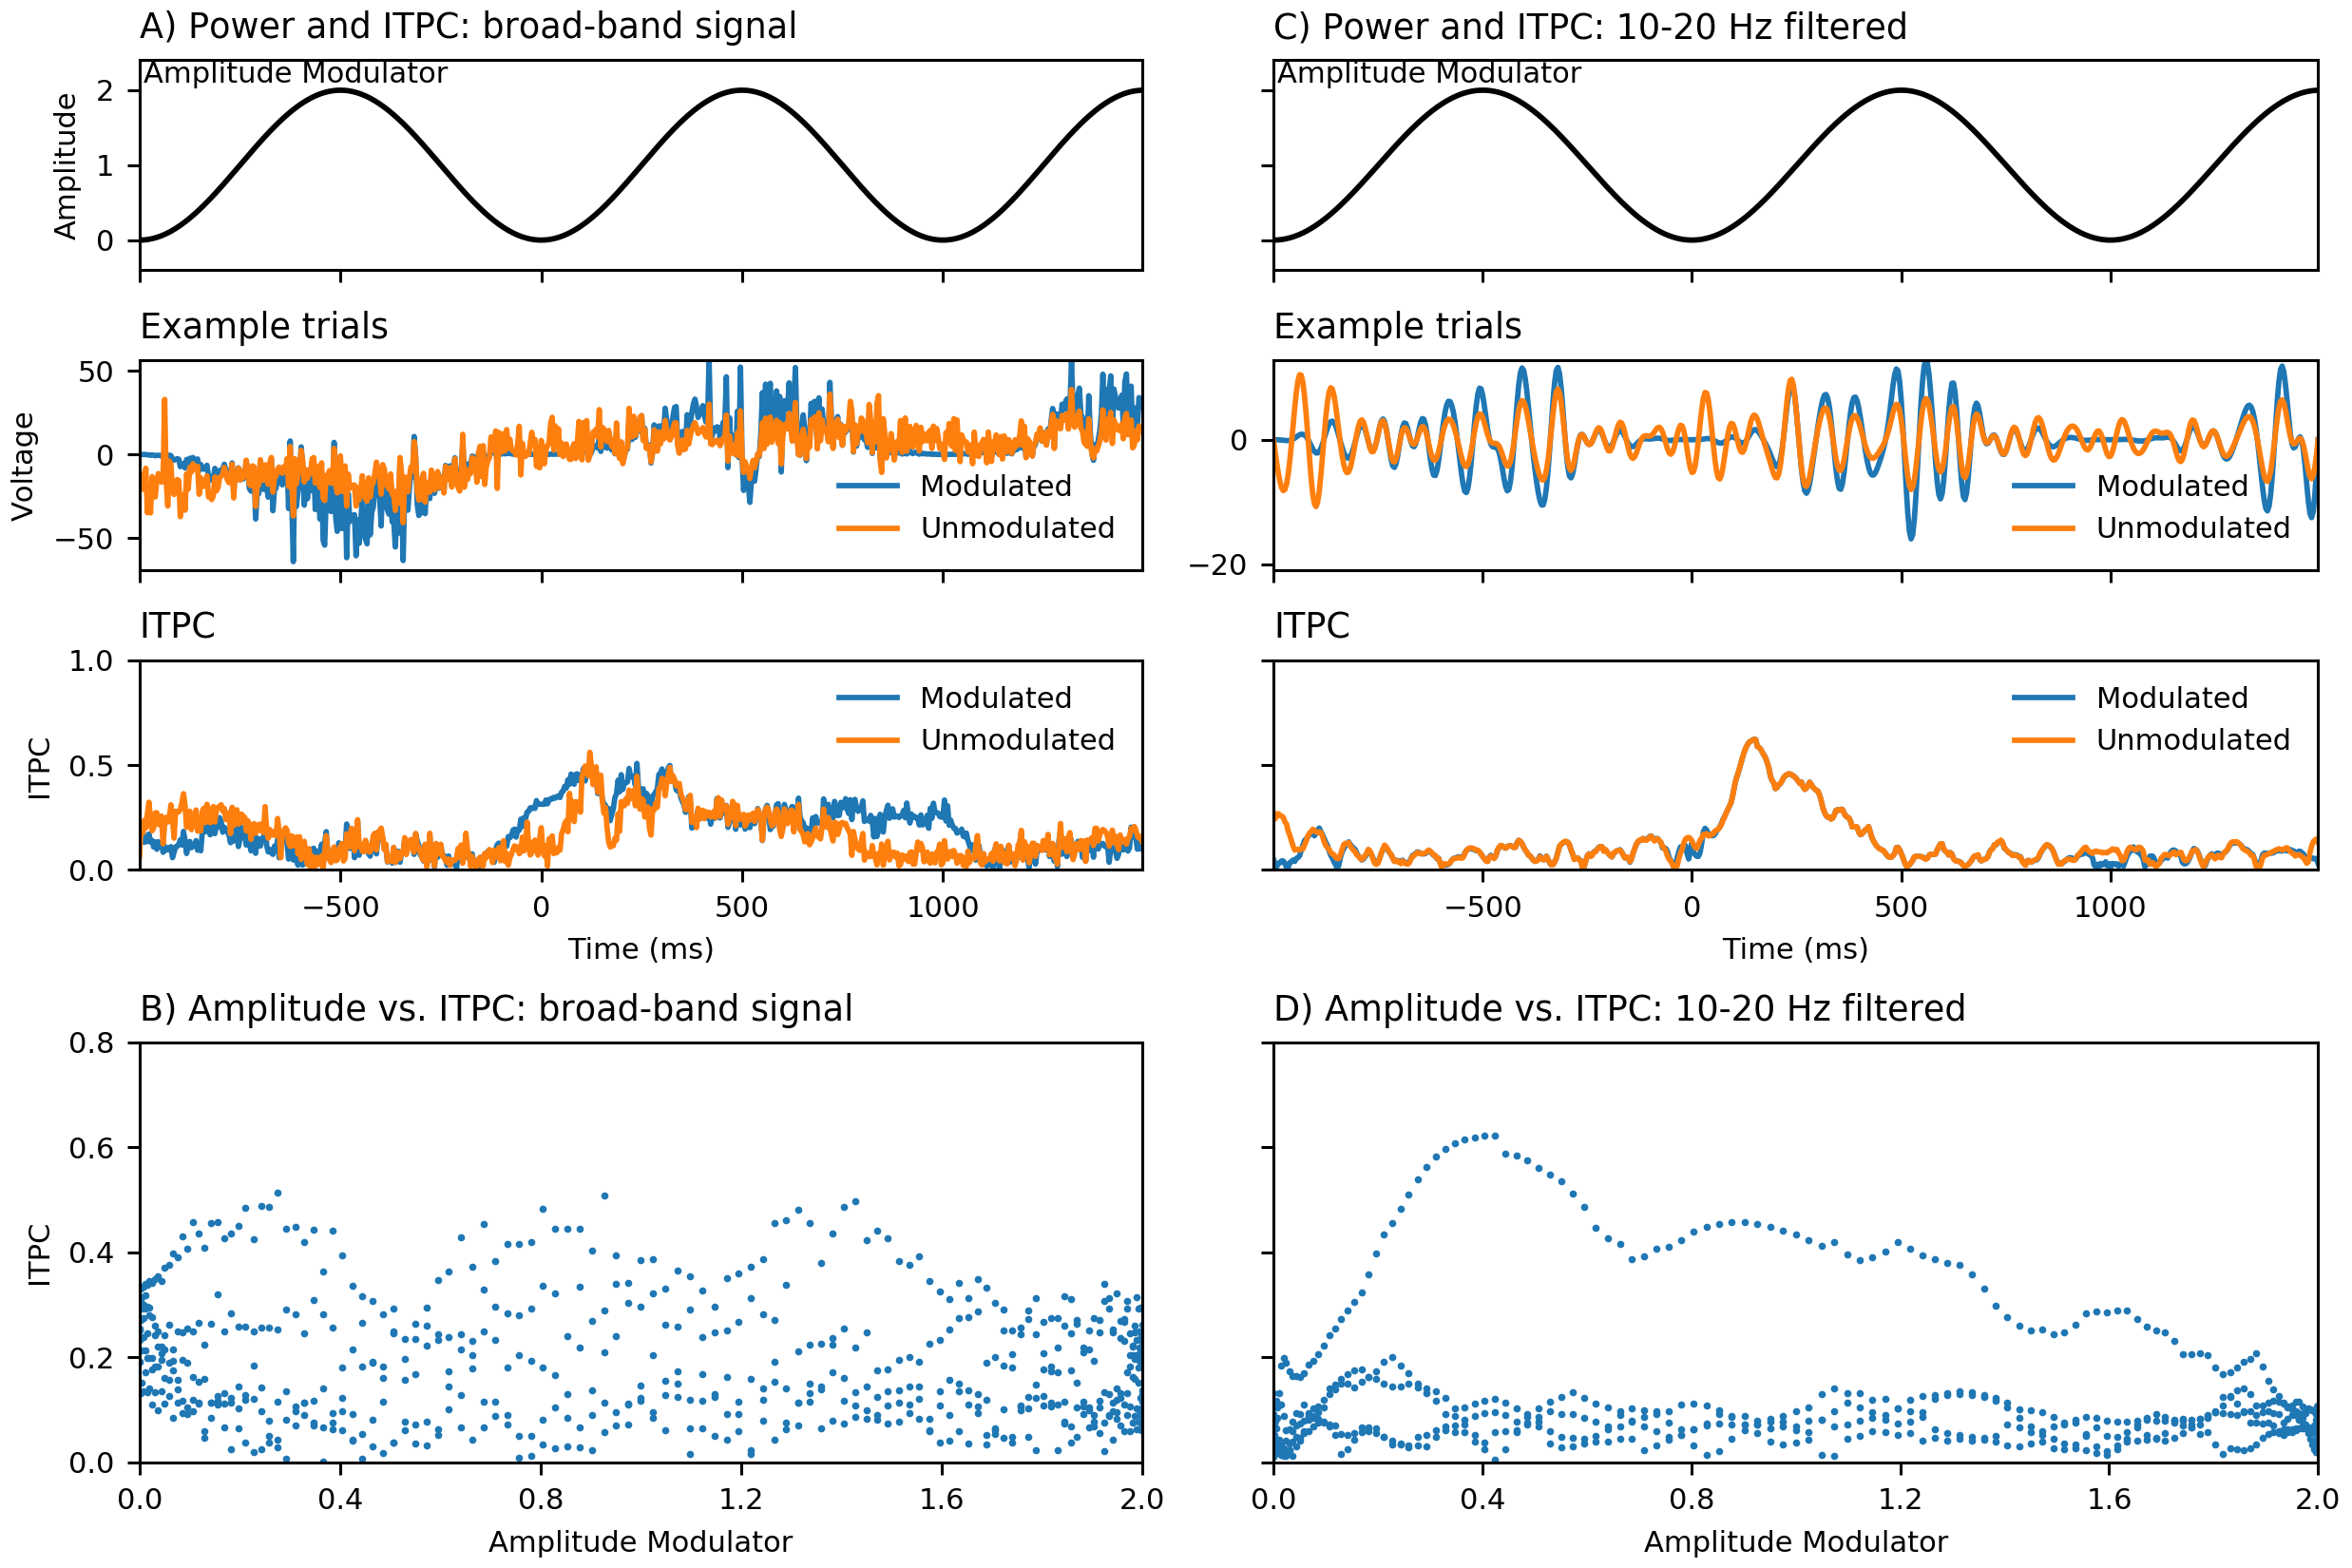

In [11]:
# This figure relies on filter_data from MNE in lieu of eegfilt from EEGLAB

# Initialize
time = time_series(samp_rate, -time_param, time_param - (time_param / samp_rate))
data_test = np.zeros([2, len(time), np.shape(eeg_data)[2]])
chan_to_plot = 'P7'
chan_idx = np.squeeze(np.where(np.array(chan_names) == chan_to_plot))

# Amplitude modulation (modulate power by 1 Hz sine wave)
amp_mod = (np.sin(2 * np.pi * 1 * time) + 2) - 1

# Set the figure and grid
fig = plt.figure(figsize=(9,6), constrained_layout=True)
full_grid = fig.add_gridspec(4, 2)

# Set the subgrids
grid_A = full_grid[:, 0].subgridspec(5, 1)
grid_B = full_grid[:, 1].subgridspec(5, 1)

title_labs = ['broad-band signal', '10-20 Hz filtered']

for i in range(2):

    for j in range(np.shape(eeg_data)[2]):
        # Each iteration is a single trial
        trial_data = eeg_data[chan_idx, :, j]
        
        if i == 1:
            trial_data = filter_data(np.float64(trial_data), 
                sfreq=samp_rate, l_freq=10, h_freq=20, verbose=False)
    
        data_test[0, :, j] = trial_data * amp_mod
        data_test[1, :, j] = trial_data
    
    # Compute ITPC
    itpc_mod = np.abs(np.mean(np.exp(1j * np.angle(hilbert(data_test[0, :, :], axis=0))), 1))
    itpc_nomod = np.abs(np.mean(np.exp(1j * np.angle(hilbert(data_test[1, :, :], axis=0))), 1))
    
    # Plot results
    if i == 0:
        grid = grid_A
        ylabs = ['Amplitude', 'Voltage', 'ITPC', 'ITPC']
        pos_idx = i
    else: 
        grid = grid_B
        ylabs = ['', '', '', '']
        pos_idx = i + 1

    ax_0 = fig.add_subplot(grid[0, 0])
    ax_0.plot(eeg_time, amp_mod, color='black')
    ax_0.set_xlim([min(eeg_time), max(eeg_time)])
    ax_0.set_ylim([-.4, 2.4])
    ax_0.set_xticklabels([])
    ax_0.set_ylabel(ylabs[0])
    ax_0.text(x=min(eeg_time) + 10, y=max(amp_mod) + .1, s='Amplitude Modulator')
    ax_0.set_title(pos_to_char(pos_idx) + ') Power and ITPC: ' + title_labs[i], loc='left')
    
    ax_1 = fig.add_subplot(grid[1, 0])
    ax_1.plot(eeg_time, data_test[0, :, 9])
    ax_1.plot(eeg_time, data_test[1, :, 9])
    ax_1.set_xlim([min(eeg_time), max(eeg_time)])
    ax_1.set_ylim([min(data_test[0, :, 9]) - 5, max(data_test[0, :, 9])])
    ax_1.set_xticklabels([])
    ax_1.set_ylabel(ylabs[1])
    ax_1.set_title('Example trials', loc='left')
    ax_1.legend(['Modulated', 'Unmodulated'], loc='lower right', frameon=False)
    
    ax_2 = fig.add_subplot(grid[2, 0])
    ax_2.plot(eeg_time, itpc_mod)
    ax_2.plot(eeg_time, itpc_nomod)
    ax_2.set_xlim([min(eeg_time), max(eeg_time)])
    ax_2.set_ylim([0, 1])
    ax_2.set_xticks(np.linspace(-500, 1000, 4))
    ax_2.set_yticks(np.linspace(0, 1, 3))
    ax_2.set_xlabel('Time (ms)')
    ax_2.set_ylabel(ylabs[2])
    ax_2.set_title('ITPC', loc='left')
    ax_2.legend(['Modulated', 'Unmodulated'], frameon=False)
    
    ax_3 = fig.add_subplot(grid[3:, 0])
    ax_3.scatter(amp_mod, itpc_mod, s=1)
    ax_3.set_xlim([min(amp_mod), max(amp_mod)])
    ax_3.set_ylim([0, .8])
    ax_3.set_xticks(np.linspace(0, 2, 6))
    ax_3.set_xlabel('Amplitude Modulator')
    ax_3.set_ylabel(ylabs[3])
    ax_3.set_title(pos_to_char(pos_idx + 1) + ') Amplitude vs. ITPC: ' + title_labs[i], loc='left')
    
    if i == 1:
        ax_0.set_yticklabels([])
        ax_2.set_yticklabels([])
        ax_3.set_yticklabels([])

### Figure 19.11

Let $b$ be a trial-varying vector (e.g., reaction time):

Weighted intertrial phase clustering (wITPC) in the time-frequency domain is defined as:

$$\textrm{wITPC}_{tf} = \mid n^{-1}\sum_{r=1}^n b_{r}e^{ik_{tfr}}\mid$$

<IPython.core.display.Javascript object>


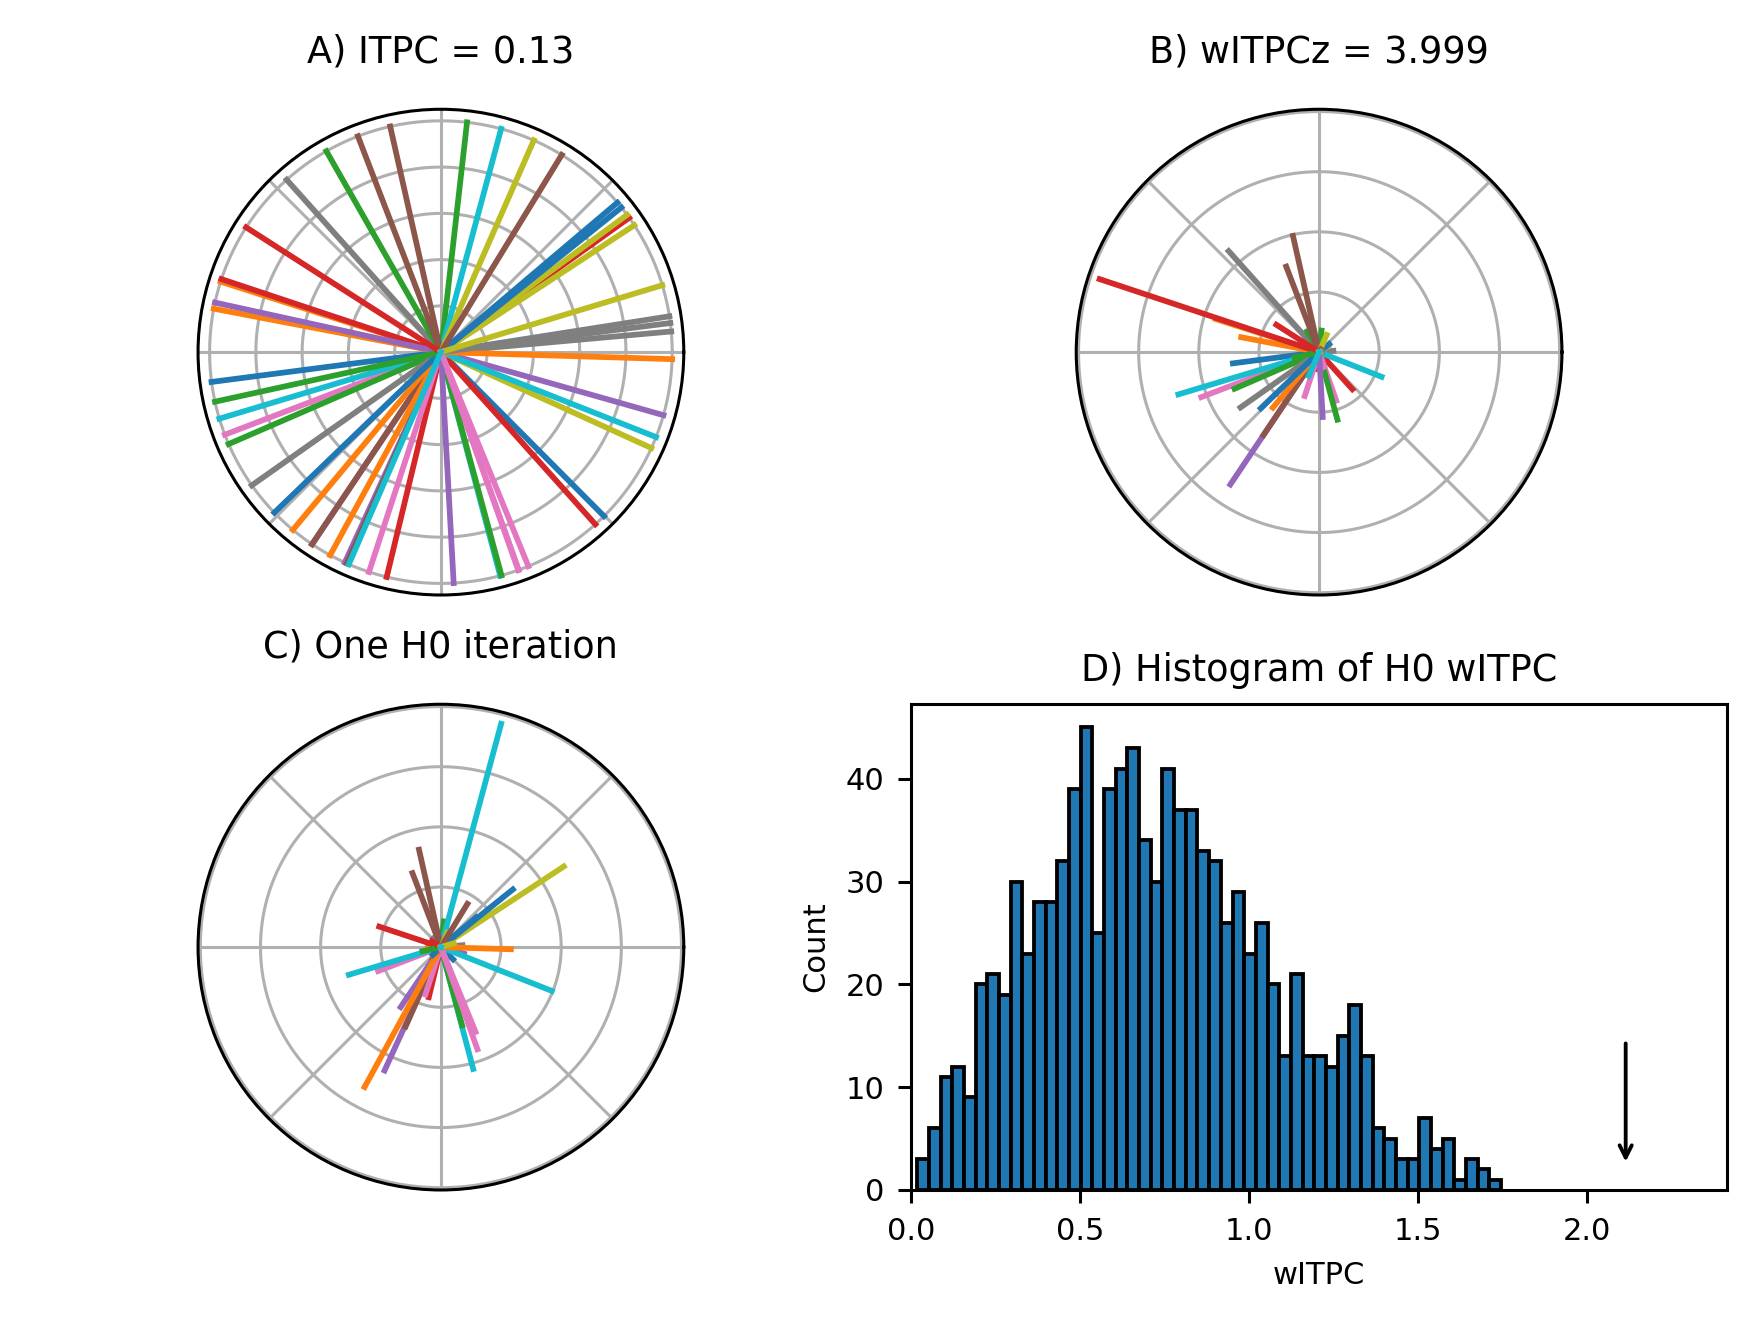

In [12]:
# Plot will be slightly different than text due to random-number generation

np.random.seed(42)

# Generate random vectors
rand_vecs = np.random.random(50) * 2 * np.pi - np.pi
vec_mod = (rand_vecs + np.random.normal(size=rand_vecs.shape)) ** 2
vec_mod_2 = vec_mod - min(vec_mod) + 1

# Compute weighted ITPC
witpc = np.abs(np.mean(vec_mod * np.exp(1j * rand_vecs)))
perm_witpc = np.zeros(1000)

for i in range(len(perm_witpc)):
    perm_witpc[i] = np.abs(np.mean(
        vec_mod[np.random.permutation(len(vec_mod))] * np.exp(1j * rand_vecs)
        ))

witpc_z = (witpc - np.mean(perm_witpc)) / np.std(perm_witpc, ddof=1)

fig = plt.figure()

iter_data = [np.ones(rand_vecs.shape), vec_mod, vec_mod[np.random.permutation(len(vec_mod))]]
titles = ['ITPC = ' + str(np.round(np.abs(np.mean(np.exp(1j * rand_vecs))), 3)), 'wITPCz = ' + str(np.round(witpc_z, 3)), 
          'One H0 iteration', 'Histogram of H0 wITPC']

for i in range(4):
    
    if i != 3:
    
        ax_pol = fig.add_subplot(2, 2, i + 1, projection='polar')
        ax_pol.plot([np.zeros(rand_vecs.shape), rand_vecs], [np.zeros(rand_vecs.shape), iter_data[i]])
        ax_pol.set_xticklabels([])
        ax_pol.set_yticklabels([])
        ax_pol.set_title(pos_to_char(i) + ') ' + titles[i])
        
    else:
        
        ax = fig.add_subplot(2, 2, i + 1)
        ax.hist(perm_witpc, bins=50, edgecolor='black')
        ax.set_xlim([0, np.max([witpc, np.max(perm_witpc)]) + .3])
        ax.set_xlabel('wITPC')
        ax.set_ylabel('Count')
        ax.annotate('', xy=(witpc, 2), xytext=(witpc, 15), arrowprops=dict(arrowstyle="->"))
        
        ax.set_title(pos_to_char(i) + ') ' + titles[i])
        
fig.tight_layout()

### Figure 19.12

<IPython.core.display.Javascript object>


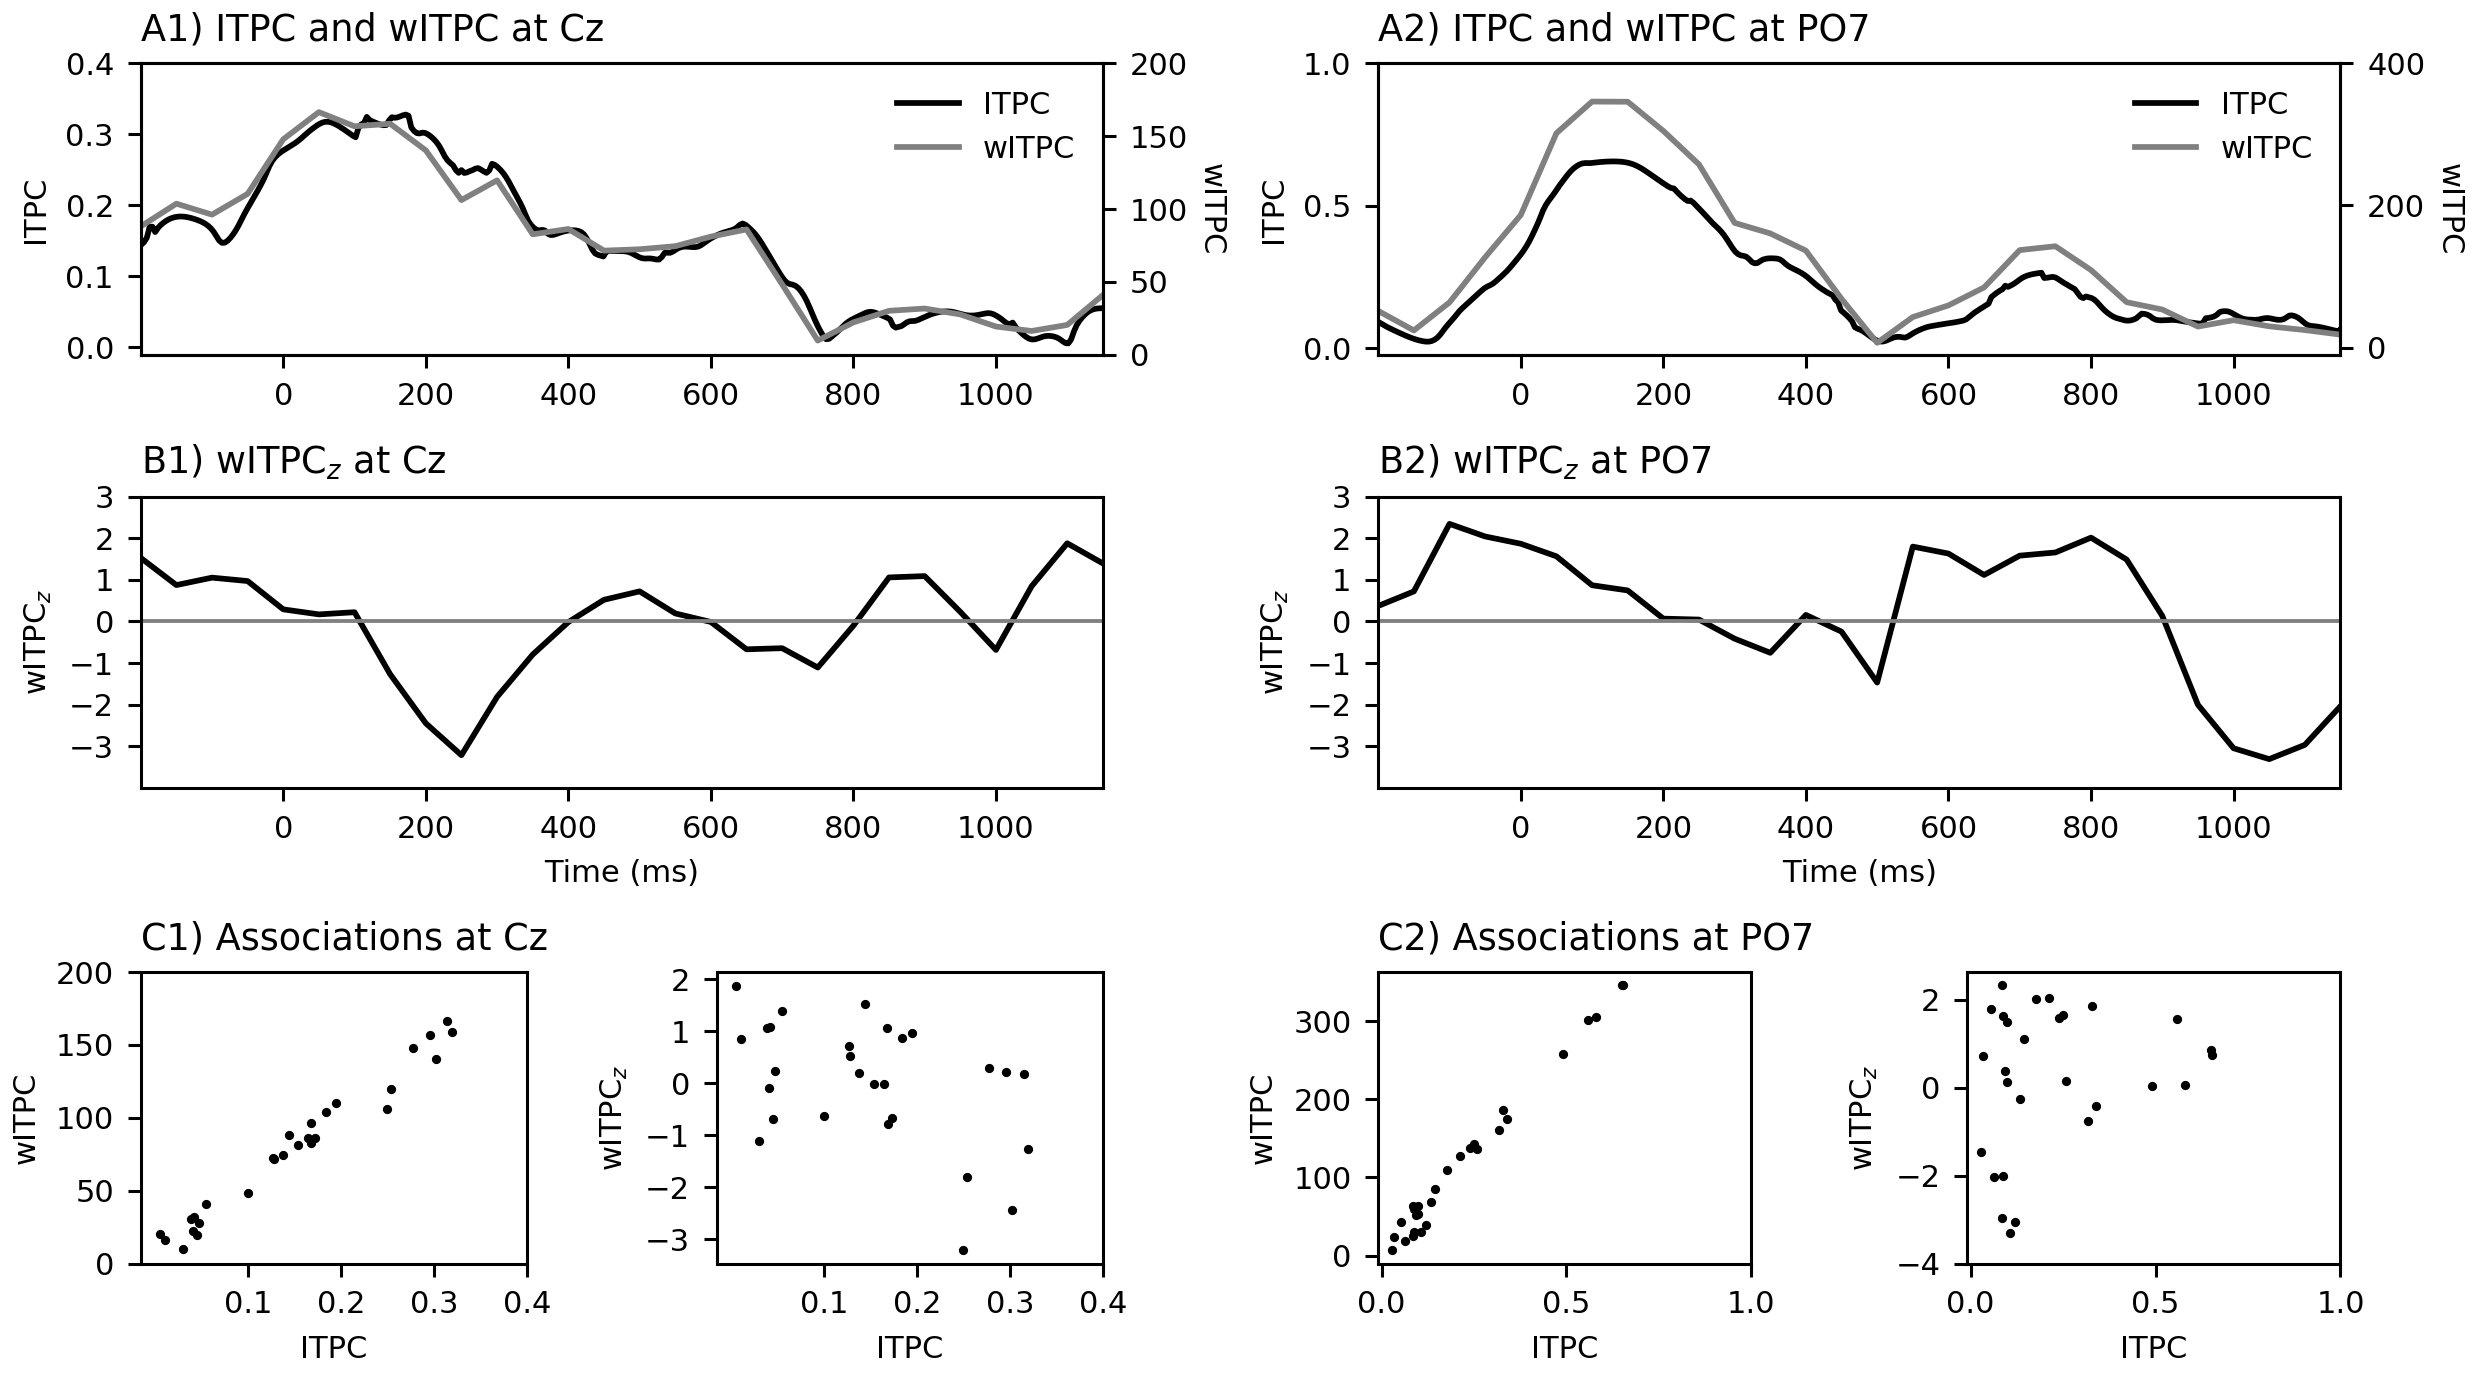

In [13]:
# Define center frequency and select channel
center_freq = 6 # Hz
chans_to_plot = ['Cz', 'PO7']
times_to_save = np.arange(-200, 1200, 50) # ms from stimulus onset

# Initialize matrix to store reaction times
rts = np.zeros(np.shape(eeg_data)[2])

for i in range(len(rts)):
    
    # Get the reaction times
    time_0_ev = np.where(np.concatenate(epochs[i]['eventlatency'] == 0))
    rts[i] = np.concatenate(epochs[i]['eventlatency'])[time_0_ev[0] + 1]
    
# Set the figure and grid
fig = plt.figure(figsize=(9, 5), constrained_layout=True)
full_grid = fig.add_gridspec(3, 4)

# Set the subgrids
grid_A = full_grid[:, 0:2].subgridspec(3, 2)
grid_B = full_grid[:, 2:].subgridspec(3, 2)

for chan in range(len(chans_to_plot)):
    
    chan_idx = np.squeeze(np.where(np.array(chan_names) == chans_to_plot[chan]))

    # Compute FFT on data and wavelet
    eeg_fft = np.fft.fft(np.reshape(eeg_data[chan_idx, :, :], n_data, order='F'), n_conv_pow2)
    wave_fft = np.fft.fft(get_sine_wave(center_freq, samp_rate, complex_wave=True,
                  start_time=-time_param, end_time=time_param - (time_param / samp_rate)) * gauss_win(
                    center_freq, samp_rate, n_cycle, normalize=False,
                    start_time=-time_param, end_time=time_param - (time_param / samp_rate)),
                          n_conv_pow2)

    # Run the convolution
    temp_conv = np.fft.ifft(wave_fft * eeg_fft)[:n_conv]
    eeg_conv = np.reshape(
        temp_conv[floor((n_wavelet - 1) / 2) - 1:len(temp_conv) - 1 - ceil((n_wavelet - 1) / 2)],
        [np.shape(eeg_data)[1], np.shape(eeg_data)[2]], order='F')

    # Extract phase angles
    phase_angles = np.angle(eeg_conv)

    # Initialize ITPC output arrays
    itpc = np.zeros(times_to_save.shape)
    witpc = itpc.copy()
    witpc_z = witpc.copy()

    for i in range(len(times_to_save)):

        # Find index for this iteration time point
        idx_obj = np.abs(eeg_time - times_to_save[i])
        idx = np.where(idx_obj == np.min(idx_obj))

        # Compute ITPC (unmodulated phase clustering)
        itpc[i] = np.abs(np.mean(np.exp(1j * phase_angles[idx, :])))

        # Compute wITPC (rts modulating the length of phase angles)
        witpc[i] = np.abs(np.mean(rts * np.exp(1j * phase_angles[idx, :])))

        # Run permutation test
        perm_witpc = np.zeros(1000)

        for j in range(len(perm_witpc)):

            perm_witpc[j] = np.abs(np.mean(rts[np.random.permutation(eeg_data.shape[2])] * np.exp(
                1j * phase_angles[idx, :])))

        witpc_z[i] = (witpc[i] - np.mean(perm_witpc)) / np.std(perm_witpc, ddof=1)
        
    # Plot results
        
    if chan == 0:
        grid = grid_A
        yticks_a = [np.linspace(0, .4, 5), np.linspace(0, 200, 5)]
        yticks_c = [np.linspace(0, 200, 5), np.arange(-3, 3)]
        xticks = np.linspace(.1, .4, 4)
        title_lab = '1'
    else: 
        grid = grid_B
        yticks_a = [np.linspace(0, 1, 3), np.linspace(0, 400, 3)]
        yticks_c = [np.linspace(0, 300, 4), np.linspace(-4, 2, 4)]
        xticks = np.linspace(0, 1, 3)
        title_lab = '2'

    ax_0 = fig.add_subplot(grid[0, :])
    line1, = ax_0.plot(eeg_time, np.abs(np.mean(np.exp(1j * phase_angles), 1)), color='black')
    ax_0.set_xlim([times_to_save[0], times_to_save[-1]])
    ax_0.set_xticks(np.linspace(0, 1000, 6))
    ax_0.set_yticks(yticks_a[0])
    ax_0.set_ylabel('ITPC')
    ax_0.set_title(pos_to_char(0) + title_lab + ') ITPC and wITPC at ' + chans_to_plot[chan], loc='left')

    # Instantiate a second axis that shares the same x-axis
    ax_twin = ax_0.twinx()
    line2, = ax_twin.plot(times_to_save, witpc, color='grey')
    ax_twin.set_yticks(yticks_a[1])
    ax_twin.set_ylabel('wITPC', rotation=270, labelpad=10)
    ax_twin.legend([line1, line2], ['ITPC', 'wITPC'], frameon=False)
    
    ax_1 = fig.add_subplot(grid[1, :])
    ax_1.plot(times_to_save, witpc_z, color='black')
    ax_1.axhline(0, color='grey', linewidth=1)
    ax_1.set_xlim([times_to_save[0], times_to_save[-1]])
    ax_1.set_ylim([-4, 3])
    ax_1.set_xticks(np.linspace(0, 1000, 6))
    ax_1.set_yticks(np.arange(-3, 4))
    ax_1.set_xlabel('Time (ms)')
    ax_1.set_ylabel(r'wITPC$_{z}$')
    ax_1.set_title(pos_to_char(1) + title_lab + r') wITPC$_{z}$ at ' + chans_to_plot[chan], loc='left')
    
    ax_2l = fig.add_subplot(grid[2, 0])
    ax_2l.scatter(itpc, witpc, s=2, color='black')
    ax_2l.set_xticks(xticks)
    ax_2l.set_yticks(yticks_c[0])
    ax_2l.set_xlabel('ITPC')
    ax_2l.set_ylabel('wITPC')
    ax_2l.set_title(pos_to_char(2) + title_lab + r') Associations at ' + chans_to_plot[chan], 
                    loc='left')
    
    ax_2r = fig.add_subplot(grid[2, 1])
    ax_2r.scatter(itpc, witpc_z, s=2, color='black')
    ax_2r.set_xticks(xticks)
    ax_2r.set_yticks(yticks_c[1])
    ax_2r.set_xlabel('ITPC')
    ax_2r.set_ylabel(r'wITPC$_{z}$')